# Análise do Classificador KFold e conjunto de dados CohQuAD In en.

Realiza a análise do classificador binário kfold utilizando BERT no conjunto de dados que alcançou a melhor acurácia.

Utiliza os arquivos resultantes da classificação kfold de `X` documentos modificados e `Y` top K predições com a melhor acurácia de classificação.

Classes:
- 1 - Documento original
- 0 - Documento modificado

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.
    """

    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))

    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.

      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.
    """

    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)

    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download
    nome_arquivo = nome_arquivo_destino.split("/")[-1]

    # Define o nome e caminho do arquivo temporário
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"

    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))

    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:
        tamanho_conteudo = data.headers.get("Content-Length")
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):
            if chunk:
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)

    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)

    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """

    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)

    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "

    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)

    sentencas = []
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())

    # Fecha o arquivo
    arquivo.close()

    return sentencas

In [7]:
def salvar(nome_arquivo,texto):
    """
      Salva um texto em arquivo.

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))

    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [9]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees

def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    para_angulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    media_como_angulo = mediaAngulo(para_angulos)
    media_segundos = media_como_angulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [10]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [11]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo para classificação

In [12]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosClassificacao:
    '''
    Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo BERT para a classificação de coerência.
    '''
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )
    num_labels: int = field(
        default=2,
        metadata={"help": "número de rótulos a serem classificados."},
    )
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    optimizer: str = field(
        default="AdamW",
        metadata={"help": "otimizador do modelo."},
    )
    use_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o uso do wandb."},
    )
    salvar_modelo_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do modelo no wandb."},
    )
    salvar_modelo : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento do modelo."},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do resultado da avaliação."},
    )
    salvar_classificacao : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento da classificação."},
    )
    usar_mcl_ajustado: bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos perturbados comparados com o seu original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de previsões de palavras recuperadas mais próximas da máscara."},
    )
    epoca: int = field(
        default="1",
        metadata={"help": "Época a ser avaliada."},
    )
    fold: int = field(
        default="1",
        metadata={"help": "Fold a ser avaliado."},
    )

Biblioteca de limpeza de tela


In [13]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [14]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [15]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [16]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [17]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.

    Retorno:
    `device` - Um device de GPU ou CPU.
    """

    # Se existe GPU disponível.
    if torch.cuda.is_available():

        # Diz ao PyTorch para usar GPU.
        device = torch.device("cuda")

        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")

    return device

In [18]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [19]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.
        `device` - Um device de GPU.

      Retorno:
        `model` - Um objeto model BERT conectado a GPU.
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()

    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [20]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  16.8 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [21]:
# # Import das bibliotecas.
# from google.colab import drive

# # Monta o drive na pasta especificada
# drive.mount("/content/drive")

from google.colab import auth
auth.authenticate_user()

from google.cloud import storage

# Initialize a client
client = storage.Client(project='mestrado-424014')

bucket_name = 'mestrado_rita_01'
bucket = client.get_bucket(bucket_name)


# Função para listar blobs dentro de uma pasta específica
def list_blobs_with_prefix(bucket_name, prefix):
    """Lists all the blobs in the bucket that begin with the prefix."""
    blobs = bucket.list_blobs(prefix=prefix)
    for blob in blobs:
        print(blob.name)

# Exemplo de uso: listar arquivos na pasta 'cohquad/'
list_blobs_with_prefix(bucket_name, 'cohquad/')

# Função para fazer download de um arquivo do GCS
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"File {source_blob_name} downloaded to {destination_file_name}.")

# Função para criar o diretório local, se não existir
def criaDiretorioLocal(diretorio_local):
    if not os.path.exists(diretorio_local):
        os.makedirs(diretorio_local)
        logging.info(f"Diretório criado: {diretorio_local}.")
    else:
        logging.info(f"Diretório já existe: {diretorio_local}.")


cohquad/
cohquad/MSRP/
cohquad/msrp_test.csv
cohquad/msrp_test.xlsx
cohquad/msrp_train.csv
cohquad/msrp_train.xlsx
cohquad/original.zip
cohquad/originalner.zip
cohquad/originalpos.zip
cohquad/sick_original.zip
cohquad/sick_originalpos.zip
cohquad/sick_test.csv
cohquad/sick_train.csv
cohquad/validacao_classificacao_palavra/
cohquad/validacao_classificacao_palavra/kfold/
cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_0_lr_1_b_16_16_f10_BERT_large.csv
cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_0_lr_1_b_16_16_f1_BERT_large.csv
cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_0_lr_1_b_16_16_f2_BERT_large.csv
cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_0_lr_1_b_16_16_f3_BERT_large.csv
cohquad/validacao_classificacao_palavra/kfold/Avali

## 1.7 Instalação do spaCy

https://spacy.io/

Modelos do spaCy para português:
https://spacy.io/models/pt

In [22]:
# Instala o spacy
!pip install -U pip setuptools wheel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.5.1
    Uninstalling setuptools-69.5.1:
      Successfully uninstalled setuptools-69.5.1
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [23]:
# Instala uma versão específica
!pip install -U spacy==3.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.3
    Uninstalling wasabi-1.1.3:
      Successfully uninstalled wasabi-1.1.3
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.0.5
    Uninstalling smart-open-7.0.5:
      Successfully uninstalled smart-open-7.0.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Successfully uninstalled pydantic-2.9.2
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: 

# 2 Parametrização

## Gerais

In [24]:
# Nome base das saidas do projeto C = Cris, SB = SmartBatch, KF = KFold
NOME_BASE_SAIDA = "AjusteFinoCohQuADInen_C_SB_KF_v1"

## Específicos

Parâmetros do modelo

In [25]:
# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosMedida(
    max_seq_len = 512,
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",

    # pretrained_model_name_or_path = "bert-large-uncased",
    pretrained_model_name_or_path = "bert-base-uncased",
    #pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    #modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",

    versao_modelo_spacy = "3.2.0",
    do_lower_case = False,  # default True
    output_attentions = False,  # default False
    output_hidden_states = True, # default False
    use_wandb = True,
    salvar_medicao = True, #Salva o resultado da medição
    salvar_avaliacao = True, # Salva o resultado da avaliação das medições
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path.
    estrategia_medida = 0, # Atributo usado para os logs do wandb. 0 - MEAN estratégia média / 1 - MAX  estratégia maior
    filtro_palavra = 0, # Atributo usado para os logs do wandb. 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
)

## Nome do diretório dos arquivos de dados

In [26]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "cohquad"

## Define o caminho para os arquivos de dados

In [27]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 spaCy

## 3.1 Download arquivo modelo

https://spacy.io/models/pt

### Função download modelo spaCy

In [28]:
def downloadSpacy(model_args):
    """
      Realiza o download do arquivo do modelo para o diretório corrente.

      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.
    """
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Nome arquivo compactado
    NOME_ARQUIVO_MODELO_COMPACTADO = ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"

    # Url do arquivo
    URL_ARQUIVO_MODELO_COMPACTADO = "https://github.com/explosion/spacy-models/releases/download/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + NOME_ARQUIVO_MODELO_COMPACTADO

    # Realiza o download do arquivo do modelo
    logging.info("Download do arquivo do modelo do spaCy.")
    downloadArquivo(URL_ARQUIVO_MODELO_COMPACTADO, DIRETORIO_COHEBERT + "/" + NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.2 Descompacta o arquivo do modelo

### Função descompacta modelo spaCy

In [29]:
# Import das bibliotecas.
import tarfile # Biblioteca de descompactação

def descompactaSpacy(model_args):
    """
      Descompacta o arquivo do modelo.

      Parâmetros:
        `model_args` - Objeto com os argumentos do modelo.
    """

    # Verifica se existe o diretório base do cohebert e retorna o nome do diretório
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy

    # Nome do arquivo a ser descompactado
    NOME_ARQUIVO_MODELO_COMPACTADO = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + ".tar.gz"

    logging.info("Descompactando o arquivo do modelo do spaCy.")
    arquivoTar = tarfile.open(NOME_ARQUIVO_MODELO_COMPACTADO, "r:gz")
    arquivoTar.extractall(DIRETORIO_COHEBERT)
    arquivoTar.close()

    # Apaga o arquivo compactado
    if os.path.isfile(NOME_ARQUIVO_MODELO_COMPACTADO):
        os.remove(NOME_ARQUIVO_MODELO_COMPACTADO)

## 3.3 Carrega o modelo

### Função carrega modelo spaCy

In [30]:
# Import das bibliotecas.
import spacy # Biblioteca do spaCy

def carregaSpacy(model_args):
    """
    Realiza o carregamento do Spacy.

    Parâmetros:
      `model_args` - Objeto com os argumentos do modelo.
    """

    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Nome arquivo spacy
    ARQUIVO_MODELO_SPACY = model_args.modelo_spacy
    # Versão spaCy
    VERSAO_SPACY = "-" + model_args.versao_modelo_spacy
    # Caminho raoz do modelo do spaCy
    DIRETORIO_MODELO_SPACY =  DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY

    # Verifica se o diretório existe
    if os.path.exists(DIRETORIO_MODELO_SPACY) == False:
        # Realiza o download do arquivo modelo do spaCy
        downloadSpacy(model_args)
        # Descompacta o spaCy
        descompactaSpacy(model_args)

    # Diretório completo do spaCy
    DIRETORIO_MODELO_SPACY = DIRETORIO_COHEBERT + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/" + ARQUIVO_MODELO_SPACY + "/" + ARQUIVO_MODELO_SPACY + VERSAO_SPACY + "/"

    # Carrega o spaCy. Necessário somente "tagger" para encontrar os substantivos
    nlp = spacy.load(DIRETORIO_MODELO_SPACY)
    logging.info("spaCy carregado.")

    # Retorna o spacy carregado
    return nlp

### Carrega o modelo spaCy


In [31]:
# Carrega o modelo spaCy
nlp = carregaSpacy(model_args)

INFO:root:Diretório Cohebert criado: cohquad
INFO:root:Download do arquivo do modelo do spaCy.
INFO:root:Download do arquivo: cohquad/en_core_web_lg-3.2.0.tar.gz.


  0%|          | 0.00/777M [00:00<?, ?B/s]

INFO:root:Descompactando o arquivo do modelo do spaCy.
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
INFO:root:spaCy carregado.


## 3.4 Funções auxiliares spaCy

### getStopwords

Recupera as stopwords do spaCy

In [32]:
def getStopwords(nlp):
    """
      Recupera as stop words do nlp(Spacy).

      Parâmetros:
        `nlp` - Um modelo spaCy carregado.
    """

    spacy_stopwords = nlp.Defaults.stop_words

    return spacy_stopwords

Lista dos stopwords

In [33]:
logging.info("Quantidade de stopwords: {}.".format(len(getStopwords(nlp))))

print(getStopwords(nlp))

INFO:root:Quantidade de stopwords: 326.


{'therein', 'across', 'becomes', 'mostly', 'other', 'thereafter', 'itself', "'m", 'upon', 'thence', 'seemed', 'per', 'get', 'yourselves', 'ca', "'ve", 'regarding', 'these', 'whereupon', 'me', 'does', 'hereby', 'whereas', 'though', '‘ll', 'front', 'there', 'amongst', 'whether', 'beside', 'a', 'along', 'but', 'we', 'formerly', 'into', 'before', 'never', 'onto', 'thereupon', 'who', 'various', 'quite', 'them', 'should', 'amount', 'below', 'otherwise', 'whoever', 'yours', 'towards', 'latterly', 'same', 'much', 'again', 'your', 'during', 'in', 'even', 'throughout', 'thus', 'say', 'former', 'several', 'show', 'his', 'above', 'another', 'indeed', "'ll", 'hereupon', 'their', 'mine', 'somewhere', 'name', 'whole', 'besides', 'neither', 'hence', 'hers', 'next', 'everywhere', 'that', 'as', 'him', 'although', 'just', 'often', 'whither', 'move', 'were', 'between', 'be', 'still', 'latter', 'alone', 'and', '‘re', 'nowhere', 'everyone', 'had', 'within', 'none', 'very', 'becoming', 'up', 'perhaps', 'unde

### getVerbos
Localiza os verbos da sentença

In [34]:
# Import das bibliotecas.
import spacy
from spacy.util import filter_spans
from spacy.matcher import Matcher

# (verbo normal como auxilar ou auxilar) + vários verbos auxiliares +verbo principal ou verbo auxiliar
gramaticav1 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar
                {"POS": "VERB", "OP": "?", "DEP": {"IN": ["ROOT","aux","xcomp","aux:pass"]}},  #verbo normal como auxiliar
                {"POS": "AUX", "OP": "*", "DEP": {"IN": ["aux","xcomp","aux:pass"]}},  #verbo auxiliar
                {"POS": "VERB", "OP": "+"}, #verbo principal
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop","aux","xcomp","aux:pass"]}},  #verbo auxiliar
               ]

# verbo auxiliar + verbo normal como auxiliar + conjunção com preposição + verbo
gramaticav2 =  [
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["aux","aux:pass"]}},  #verbo auxiliar
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["ROOT"]}},  #verbo principal
                {"POS": "SCONJ", "OP": "+", "DEP": {"IN": ["mark"]}}, #conjunção com preposição
                {"POS": "VERB", "OP": "+", "DEP": {"IN": ["xcomp"]}}, #verbo normal como complementar
               ]

#Somente verbos auxiliares
gramaticav3 =  [
                {"POS": "AUX", "OP": "?"},  #Verbos auxiliar
                {"POS": "AUX", "OP": "?", "DEP": {"IN": ["cop"]}},  #Verbos auxiliar de ligação (AUX+(cop))
                {"POS": "ADJ", "OP": "+", "DEP": {"IN": ["ROOT"]}},
                {"POS": "AUX", "OP": "?"}  #Verbos auxiliar
               ]

matcherv = Matcher(nlp.vocab)

matcherv.add("frase verbal", [gramaticav1])
matcherv.add("frase verbal", [gramaticav2])
matcherv.add("frase verbal", [gramaticav3])

#Retorna a Frase Verbal
def getVerbos(periodo):
  #Processa o período
  doc1 = nlp(periodo.text)

  # Chama o mather para encontrar o padrão
  matches = matcherv(doc1)

  padrao = [doc1[start:end] for _, start, end in matches]

  #elimina as repetições e sobreposições
  #return filter_spans(padrao)
  lista1 = filter_spans(padrao)

  # Converte os itens em string
  lista2 = []
  for x in lista1:
      lista2.append(str(x))

  return lista2

### getDicPOSQtde

Conta as POS Tagging de uma sentença

In [35]:
def getDicPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novodic = dict()

  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novodic[classe_gramatical] = qtde

  return novodic

In [36]:
def getDicTodasPOSQtde(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Retorna inteiros que mapeiam para classes gramaticais
  conta_dicionarios = doc.count_by(spacy.attrs.IDS["POS"])

  # Dicionário com as tags e quantidades
  novodic = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ":0, "X": 0}

  for pos, qtde in conta_dicionarios.items():
    classe_gramatical = doc.vocab[pos].text
    novodic[classe_gramatical] = qtde

  return novodic

### getDicTodasPOSQtde

Conta as POS Tagging de uma sentença

In [37]:
def getDicTodasPOSQtde(lista):

  # Dicionário com as tags e quantidades
  conjunto = {"PRON":0, "VERB":0, "PUNCT":0, "DET":0, "NOUN":0, "AUX":0, "CCONJ":0, "ADP":0, "PROPN":0, "ADJ":0, "ADV":0, "NUM":0, "SCONJ":0, "SYM":0, "SPACE":0, "INTJ": 0}

  for x in lista:
    valor = conjunto.get(x)
    if valor != None:
      conjunto[x] = valor + 1
    else:
      conjunto[x] = 1

  return conjunto

### getSomaDic

Soma os valores de dicionários com as mesmas chaves.

In [38]:
from collections import Counter
from functools import reduce

def atualizaValor(a,b):
    a.update(b)
    return a

def getSomaDic(lista):

  # Soma os dicionários da lista
  novodic = reduce(atualizaValor, (Counter(dict(x)) for x in lista))

  return novodic

### getTokensSentenca

Retorna a lista de tokens da sentenca.

In [39]:
def getTokensSentenca(sentenca):

    # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:
    lista.append(token.text)

  return lista

### getPOSTokensSentenca

Retorna a lista das POS-Tagging dos tokens da sentenca.

In [40]:
def getPOSTokensSentenca(sentenca):

  # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  lista = []

  # Percorre a sentença adicionando os tokens
  for token in doc:
    lista.append(token.pos_)

  return lista

### getListaTokensPOSSentenca

Retorna duas listas uma com os tokens e a outra com a POS-Tagging dos tokens da sentenca.

In [41]:
def getListaTokensPOSSentenca(sentenca):
  # Verifica se o sentenca não foi processado pelo spaCy
  if type(sentenca) is not spacy.tokens.doc.Doc:
      # Realiza o parsing no spacy
      doc = nlp(sentenca)
  else:
      doc = sentenca

  # Lista dos tokens
  listatokens = []
  listapos = []

  # Percorre a sentença adicionando os tokens e as POS
  for token in doc:
    listatokens.append(token.text)
    listapos.append(token.pos_)

  return listatokens, listapos

### Tradução das tags

Tags de palavras universal

https://universaldependencies.org/u/pos/

Detalhes das tags em português:
http://www.dbd.puc-rio.br/pergamum/tesesabertas/1412298_2016_completo.pdf

In [42]:
#dicionário que contêm pos tag universal e suas explicações
palavra_universal_dict = {
  "X"    : "Outro",
  "VERB" : "Verbo ",
  "SYM"  : "Símbolo",
  "CONJ" : "Conjunção",
  "SCONJ": "Conjunção subordinativa",
  "PUNCT": "Pontuação",
  "PROPN": "Nome próprio",
  "PRON" : "Pronome substativo",
  "PART" : "Partícula, morfemas livres",
  "NUM"  : "Numeral",
  "NOUN" : "Substantivo",
  "INTJ" : "Interjeição",
  "DET"  : "Determinante, Artigo e pronomes adjetivos",
  "CCONJ": "Conjunção coordenativa",
  "AUX"  : "Verbo auxiliar",
  "ADV"  : "Advérbio",
  "ADP"  : "Preposição",
  "ADJ"  : "Adjetivo"
}

#Explica a POS
def getPOSPalavraUniversalTraduzido(palavra):
  if palavra in palavra_universal_dict.keys():
      traduzido = palavra_universal_dict[palavra]
  else:
      traduzido = "NA"
  return traduzido

### getSentencaSemStopWord

Retorna uma lista dos tokens sem as stopwords.

In [43]:
def getSentencaSemStopWord(sentenca, stopwords):

  # Lista dos tokens
  lista = []

  # Percorre os tokens da sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é uma stopword
    if token.lower() not in stopwords:
      lista.append(token)

  # Retorna o documento
  return lista

### getSentencaSalientePOS

Retorna uma lista das palavras do tipo especificado.

In [44]:
def getSentencaSalientePOS(sentenca, pos, classe_saliente=["NOUN"]):

  # Lista dos tokens
  lista = []

  # Percorre a sentença
  for i, token in enumerate(sentenca):

    # Verifica se o token é do tipo especificado
    if pos[i] in classe_saliente:
      lista.append(token)

  # Retorna o documento
  return lista

###removeStopWords

Remove as stopwords de um documento ou senteça.

In [45]:
def removeStopWord(documento, stopwords):

  # Remoção das stopwords do documento
  documentoSemStopwords = [palavra for palavra in documento.split() if palavra.lower() not in stopwords]

  # Concatena o documento sem os stopwords
  documento_limpo = " ".join(documentoSemStopwords)

  # Retorna o documento
  return documento_limpo

# 4 Resultado do Classificador Binário usando o Método Kfold

## 4.1 Carrega o resultado e parâmetros da melhor classificação

### 4.1.1 Função que encontra a melhor classificação

In [46]:
# Import das bibliotecas.
import os
import pandas as pd
from google.cloud import storage
from io import BytesIO

def getResultadosClassificacaoKFold(DIRETORIO_COHEBERT,
                                    _DOCUMENTOS_PERTURBADOS,
                                    _TOP_K_PREDICAO,
                                    _MODELO_BERT):

  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara.
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = _MODELO_BERT

  # TAMANHO_BERT = ['_base']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = [1, 2, 3, 4, 5]

  # Tamanho dos lotes
  TAMANHO_LOTE = [16] #,32]

  # Salva resultados intermediários
  EPOCA = [1, 2, 3, 4]

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"

  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_TAXAS_DE_APRENDIZAGEM = 0
  MELHOR_TAMANHO_LOTE = 0
  MELHOR_EPOCA_EXECUCAO = 0
  MELHOR_ACURACIA = 0
  MELHOR_TEMPO = 0

  lista_resultados = []

  lista_tempo_total = []

  blobs = bucket.list_blobs(prefix=DIRETORIO_AVALIACAO)  # Modificado para listar blobs
  arquivos = [blob.name for blob in blobs if not blob.name.endswith('/')]
  # Verifica se o diretório dos resultados existe.
  if arquivos:
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_base':
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:
              if documentos_perturbados ==  top_k_predicao:
                DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"
                # Verifica se o diretório dos resultados existe.
                # print(DIRETORIO_AVALIACAO_PK)
                if any(DIRETORIO_AVALIACAO_PK in arquivo for arquivo in arquivos):
                  conta_regR = 0
                  for lote in TAMANHO_LOTE:
                    for taxa_de_aprendizagem in TAXAS_DE_APRENDIZAGEM:
                      for epoca in EPOCA:
                          # Acumuladores.
                          soma_acuracia = 0
                          lista_tempo = []
                          conta_folds = 0
                          conta_reg = 0

                          for arquivo in arquivos:
                            # print(arquivo)
                            for fold in range(1,11):
                              # Filtra o nome do arquivo a ser avaliado
                              # condition1 = ("_P_" + str(documentos_perturbados) + "_") in arquivo
                              # condition2 = ("_K_" + str(top_k_predicao) + "_") in arquivo
                              # condition3 = ("_b_" + str(lote)) in arquivo  # Corrigido, removendo duplicação de str(lote)
                              # condition4 = modelo in arquivo
                              # condition5 = tamanho in arquivo
                              # condition6 = ('_f' + str(fold) + '_') in arquivo
                              # condition7 = ("e_" + str(epoca)) in arquivo
                              # condition8 = ("lr_" + str(taxa_de_aprendizagem)) in arquivo

                              # print(f"condition1: {condition1}, condition2: {condition2}, condition3: {condition3}, condition4: {condition4}, condition5: {condition5}, condition6: {condition6}, condition7: {condition7}, condition8: {condition8}")
                              if ((("_P_" + str(documentos_perturbados)+"_") in arquivo)
                                    and (("_K_" + str(top_k_predicao)+"_") in arquivo)
                                    and (("_b_" + str(lote)) in arquivo)
                                    and (modelo in arquivo)
                                    and (tamanho in arquivo)
                                    and (('_f' + str(fold) + '_') in arquivo)
                                    and (("e_" + str(epoca)) in arquivo)
                                    and (("lr_" + str(taxa_de_aprendizagem)) in arquivo)):

                                  blob = bucket.blob(arquivo)
                                  content = blob.download_as_bytes()
                                  dados = pd.read_csv(BytesIO(content), sep=';')
                                  # print(dados)
                                  # Conta o número de folds.
                                  conta_folds = conta_folds + 1

                                  # Mostra os dados do teste do fold.
                                  for index, linha in dados.iterrows():
                                    # Cálculo das estatísticas
                                    acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])
                                    #print('{};{};{};{:.8f};{}'.format(fold, index, arquivo,acc,linha['tempo']))
                                    # Guarda o tempo.
                                    lista_tempo.append(str(linha['tempo']))
                                    # Conta o número de registros.
                                    conta_reg = conta_reg + 1

                                  # Realiza a soma da acurácia do arquivo.
                                  soma_acuracia = soma_acuracia + dados['acuracia'].sum()

                          if conta_folds != 0:
                            # Calcula a média.
                            media_acuracia = soma_acuracia/conta_reg

                            # Guarda os resultados de todos os folds
                            lista_resultados.append([documentos_perturbados,top_k_predicao,taxa_de_aprendizagem,lote,epoca, media_acuracia, somaTempo(lista_tempo)])

                            if media_acuracia > MELHOR_ACURACIA:
                                MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                MELHOR_TOP_K_PREDICAO = top_k_predicao
                                MELHOR_TAXAS_DE_APRENDIZAGEM = taxa_de_aprendizagem
                                MELHOR_TAMANHO_LOTE = lote
                                MELHOR_EPOCA_EXECUCAO = epoca
                                MELHOR_ACURACIA = media_acuracia
                                MELHOR_TEMPO = somaTempo(lista_tempo)

                          else:
                              print('Nenhum arquivo de avaliação encontrado')

                else:
                  print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')

    # Retorno do melhor valor
    lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[5], reverse=True)
    return MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultado_ordenado
  else:
    print('Diretório com os resultados não encontrado')


Recupera os melhores resultados

In [47]:
DOCUMENTOS_PERTURBADOS = [1]
TOP_K_PREDICAO = [1]
MODELO_BERT = ['_BERT']

# Recupera os melhores parâmetros
MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_TAXAS_DE_APRENDIZAGEM, MELHOR_TAMANHO_LOTE, MELHOR_EPOCA_EXECUCAO, MELHOR_ACURACIA, MELHOR_TEMPO, lista_resultados = getResultadosClassificacaoKFold(DIRETORIO_COHEBERT,
                                                                                                                                                                                                                  DOCUMENTOS_PERTURBADOS,
                                                                                                                                                                                                                  TOP_K_PREDICAO,
                                                                                                                                                                                                                  MODELO_BERT)

In [48]:
print("Parâmetros da melhor acurácia do classificador")
print("\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS,
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO,
      "\n  Taxa de aprendizagem  :", MELHOR_TAXAS_DE_APRENDIZAGEM,
      "\n  Lote                  :", MELHOR_TAMANHO_LOTE,
      "\n  Epoca execução        :", MELHOR_EPOCA_EXECUCAO,
      "\n  Acurácia              :", MELHOR_ACURACIA,
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista das acurácias ranqueadas")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros da melhor acurácia do classificador

  Documentos Perturbados: 1 
  Top k predição        : 1 
  Taxa de aprendizagem  : 1 
  Lote                  : 16 
  Epoca execução        : 4 
  Acurácia              : 0.5474188070689199 
  Tempo execução        : 01:04:12

Lista das acurácias ranqueadas
1 = [1, 1, 1, 16, 4, 0.5474188070689199, '01:04:12']
2 = [1, 1, 2, 16, 3, 0.5456215809488948, '00:48:24']
3 = [1, 1, 3, 16, 2, 0.5453963557236695, '00:34:59']
4 = [1, 1, 4, 16, 1, 0.5449549179797486, '00:46:54']
5 = [1, 1, 3, 16, 1, 0.5449459052732191, '00:18:17']
6 = [1, 1, 3, 16, 3, 0.5449459052732191, '00:51:38']
7 = [1, 1, 5, 16, 1, 0.5444954548227686, '00:18:06']
8 = [1, 1, 4, 16, 3, 0.544340667365498, '02:14:55']
9 = [1, 1, 1, 16, 2, 0.5420179773452911, '00:32:46']
10 = [1, 1, 2, 16, 2, 0.5411170764443902, '00:32:45']
11 = [1, 1, 1, 16, 3, 0.5393025644154312, '00:48:24']
12 = [1, 1, 4, 16, 2, 0.5386076616324924, '01:30:53']
13 = [1, 1, 1, 16, 1, 0.5372882476155614, '00:17:07']
1

### Escolhendo um resultado diferente do melhor

In [49]:
# Parametros para melhor de 100
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_TAXAS_DE_APRENDIZAGEM = 1
# MELHOR_TAMANHO_LOTE = 32
# MELHOR_EPOCA_EXECUCAO = 4
# MELHOR_ACURACIA = 0.9977500000000001
# MELHOR_TEMPO = '00:30:42'
# lista_resultados= []

# Parametros para melhor de 20
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_TAXAS_DE_APRENDIZAGEM = 3
# MELHOR_TAMANHO_LOTE = 16
# MELHOR_EPOCA_EXECUCAO = 3
# MELHOR_ACURACIA =  0.9550000000000001
# MELHOR_TEMPO = '00:14:33'
# lista_resultados= []

# #Parametros para melhor de 1
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_TAXAS_DE_APRENDIZAGEM = 2
# MELHOR_TAMANHO_LOTE = 16
# MELHOR_EPOCA_EXECUCAO = 4
# MELHOR_ACURACIA = 0.725
# MELHOR_TEMPO = '00:10:38'
# lista_resultados= []

### 4.1.2 Função que carrega e calcula a média da acurácia dos folds


In [50]:
# Import das bibliotecas.
import os
import pandas as pd
from google.cloud import storage
from io import BytesIO

def relatorioResultados(DIRETORIO_COHEBERT,
                        TEXTO_PURO,
                        _DOCUMENTOS_PERTURBADOS,
                        _TOP_K_PREDICAO,
                        _TAXAS_DE_APRENDIZAGEM,
                        _TAMANHO_LOTE,
                        _EPOCA_EXECUCAO,
                        _MODELO_BERT = ['_BERT']):
  # Numero de Folds
  KFOLDS = 10

  # Quantidade de documentos a serem perturbados a partir do original.
  DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara.
  TOP_K_PREDICAO = _TOP_K_PREDICAO

  # MCL a serem avaliados
  MODELO_BERT = _MODELO_BERT

  #TAMANHO_BERT = ['_base','_large']
  TAMANHO_BERT = ['_large']

  # Taxa de aprendizagem do nome do arquivo
  TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

  # Tamanho dos lotes
  TAMANHO_LOTE = _TAMANHO_LOTE

  # Salva resultados intermediários
  EPOCA = _EPOCA_EXECUCAO

  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"

  lista_tempo_total = []
  total_geral_folds = 0
  total_geral_registros = 0
  total_arquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
                   len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) *
                   len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
  #total_arquivos = 400
  if TEXTO_PURO == False:
    print("total_arquivos =", total_arquivos)

  # Verifica se o diretório dos resultados existe.
  blobs = bucket.list_blobs(prefix=DIRETORIO_AVALIACAO)  # Modificado para listar blobs
  arquivos = [blob.name for blob in blobs if not blob.name.endswith('/')]

  if arquivos:
    for modelo in MODELO_BERT:
      for tamanho in TAMANHO_BERT:
        if modelo != '_BERTmultilingual' or tamanho != '_large':
          for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
            for top_k_predicao in TOP_K_PREDICAO:
              if documentos_perturbados ==  top_k_predicao:
                DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"

                # Verifica se o diretório dos resultados existe.
                if any(DIRETORIO_AVALIACAO_PK in arquivo for arquivo in arquivos):
                  for lote in TAMANHO_LOTE:
                    for taxa_de_aprendizagem in TAXAS_DE_APRENDIZAGEM:
                      for epoca in EPOCA:
                          # Acumuladores.
                          soma_acuracia = 0
                          lista_tempo = []
                          conta_folds = 0
                          conta_reg = 0
                          if TEXTO_PURO == False:
                            print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
                                  " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxa_de_aprendizagem, " Época:", epoca)

                          for arquivo in arquivos:
                            for fold in range(1, 11):
                              if ((("_P_" + str(documentos_perturbados) + "_") in arquivo)
                                  and (("_K_" + str(top_k_predicao) + "_") in arquivo)
                                  and (("_b_" + str(lote)) in arquivo)
                                  and (modelo in arquivo)
                                  and (tamanho in arquivo)
                                  and (("_b_" + str(lote)) in arquivo)
                                  and (('_f' + str(fold) + '_') in arquivo)
                                  and (("e_" + str(epoca)) in arquivo)
                                  and (("lr_" + str(taxa_de_aprendizagem)) in arquivo)):

                                blob = bucket.blob(arquivo)
                                content = blob.download_as_bytes()
                                dados = pd.read_csv(BytesIO(content), sep=';')

                                # Conta o número de folds.
                                conta_folds += 1
                                # Conta o número geral de folds
                                total_geral_folds += 1

                                # Mostra os dados do teste do fold.
                                for index, linha in dados.iterrows():
                                  # Cálculo das estatísticas
                                  acc = (linha['vp'] + linha['vn']) / (linha['vp'] + linha['vn'] + linha['fp'] + linha['fn'])
                                  print('{};{};{};{};{}'.format(fold, index, arquivo, str(acc).replace(".", ","), linha['tempo']))
                                  # Guarda o tempo.
                                  lista_tempo.append(str(linha['tempo']))

                                  # Conta o número de registros.
                                  conta_reg += 1
                                  # Conta o número geral de registros.
                                  total_geral_registros += 1

                                # Realiza a soma da acurácia do arquivo.
                                soma_acuracia += dados['acuracia'].sum()

                          if conta_folds != 0:
                              # Mostra a soma da acurácia .
                              if TEXTO_PURO == False:
                                print('Total acurácia                                           : {:.8f}'.format(soma_acuracia))
                              # Mostra a quantidade de folds.
                              if TEXTO_PURO == False:
                                print('Quantidade de folds                                      : {}'.format(conta_folds))
                              # Mostra a quantidade de registros.
                              if TEXTO_PURO == False:
                                print('Quantidade de registros                                  : {}'.format(conta_reg))
                              # Calcula a média.
                              if TEXTO_PURO == False:
                                media_acuracia = soma_acuracia / conta_reg
                                print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(conta_reg, media_acuracia))
                                print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(conta_reg, somaTempo(lista_tempo)))
                                print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(conta_reg, mediaTempo(lista_tempo)))

                              if epoca == 4:
                                # Guarda o tempo total
                                lista_tempo_total.append(somaTempo(lista_tempo))
                          else:
                              if TEXTO_PURO == False:
                                print('Nenhum arquivo de avaliação encontrado')

                else:
                  print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')

  else:
      print('Diretório com os resultados não encontrado')


# # Import das bibliotecas.
# import os
# import pandas as pd

# def relatorioResultados(DIRETORIO_COHEBERT,
#                         TEXTO_PURO,
#                         _DOCUMENTOS_PERTURBADOS,
#                         _TOP_K_PREDICAO,
#                         _TAXAS_DE_APRENDIZAGEM,
#                         _TAMANHO_LOTE,
#                         _EPOCA_EXECUCAO,
#                         _MODELO_BERT = ['_BERTimbau']):

#   # Numero de Folds
#   KFOLDS = 10

#   # Quantidade de documentos a serem perturbados a partir do original.
#   DOCUMENTOS_PERTURBADOS = _DOCUMENTOS_PERTURBADOS

#   # Quantidade de palavras a serem recuperadas mais próximas da máscara.
#   TOP_K_PREDICAO = _TOP_K_PREDICAO

#   # MCL a serem avaliados
#   #MODELO_BERT = ['_BERTimbau','_BERTmultilingual']
#   MODELO_BERT = _MODELO_BERT

#   #TAMANHO_BERT = ['_base','_large']
#   TAMANHO_BERT = ['_large']

#   # Taxa de aprendizagem do nome do arquivo
#   TAXAS_DE_APRENDIZAGEM = _TAXAS_DE_APRENDIZAGEM

#   # Tamanho dos lotes
#   TAMANHO_LOTE = _TAMANHO_LOTE

#   # Salva resultados intermediários
#   EPOCA = _EPOCA_EXECUCAO

#   # Diretório para salvar o arquivo.
#   DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Avaliacao/"

#   lista_tempo_total = []
#   total_geral_folds = 0
#   total_geral_registros = 0
#   total_arquivos = (len(MODELO_BERT) * len(TAMANHO_BERT) *
#                    len(DOCUMENTOS_PERTURBADOS) *  len(TOP_K_PREDICAO) *
#                    len(TAMANHO_LOTE) * len(EPOCA) * len(TAXAS_DE_APRENDIZAGEM) * KFOLDS)
#   #total_arquivos = 400
#   if TEXTO_PURO == False:
#     print("total_arquivos =", total_arquivos)

#   # Verifica se o diretório dos resultados existe.
#   if os.path.exists(DIRETORIO_AVALIACAO):
#     for modelo in MODELO_BERT:
#       for tamanho in TAMANHO_BERT:
#         if modelo != '_BERTmultilingual' or tamanho != '_large':
#           for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
#             for top_k_predicao in TOP_K_PREDICAO:
#               if documentos_perturbados ==  top_k_predicao:
#                 DIRETORIO_AVALIACAO_PK = DIRETORIO_AVALIACAO + "P_" + str(documentos_perturbados) + "_K_" + str(top_k_predicao) + "/"

#                 # Verifica se o diretório dos resultados existe.
#                 if os.path.exists(DIRETORIO_AVALIACAO_PK):
#                   arquivos = os.listdir(DIRETORIO_AVALIACAO_PK)
#                   for lote in TAMANHO_LOTE:
#                     for taxa_de_aprendizagem in TAXAS_DE_APRENDIZAGEM:
#                       for epoca in EPOCA:
#                           # Acumuladores.
#                           soma_acuracia = 0
#                           lista_tempo = []
#                           conta_folds = 0
#                           conta_reg = 0
#                           if TEXTO_PURO == False:
#                             print("\nModelo:", modelo, " Tamanho:", tamanho, " N Doc:",documentos_perturbados,
#                                   " Top k:", top_k_predicao, " Lote:", lote, " Taxa Apred.:", taxa_de_aprendizagem, " Época:", epoca)

#                           for i in range(len(arquivos)):
#                             for fold in range(1,11):
#                               if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i])
#                                   and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])
#                                   and (("_b_" + str(lote)) in arquivos[i])
#                                   and (modelo in arquivos[i])
#                                   and (tamanho in arquivos[i])
#                                   and (("_b_" + str(lote)) in arquivos[i])
#                                   and (('_f' + str(fold) + '_') in arquivos[i])
#                                   and (("e_" + str(epoca)) in arquivos[i])
#                                   and (("lr_" + str(taxa_de_aprendizagem)) in arquivos[i])):

#                                   NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO_PK + arquivos[i]
#                                   # Verifica se o arquivo existe.
#                                   if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
#                                     # Carrega os dados do arquivo
#                                     dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')

#                                     # Conta o número de folds.
#                                     conta_folds = conta_folds + 1
#                                     # Conta o número geral de folds
#                                     total_geral_folds = total_geral_folds + 1

#                                     # Mostra os dados do teste do fold.
#                                     for index, linha in dados.iterrows():
#                                       # Cálculo das estatísticas
#                                       acc = (linha['vp']+linha['vn'])/(linha['vp']+linha['vn']+linha['fp']+linha['fn'])
#                                       print('{};{};{};{};{}'.format(fold, index, arquivos[i],str(acc).replace(".", ","),linha['tempo']))
#                                       #print('{};{};{};{:.8f};{}'.format(fold, index, arquivos[i],acc,linha['tempo']))
#                                       # Guarda o tempo.
#                                       lista_tempo.append(str(linha['tempo']))

#                                       # Conta o número de registros.
#                                       conta_reg = conta_reg + 1
#                                       # Conta o número geral de registros.
#                                       total_geral_registros = total_geral_registros + 1

#                                     # Realiza a soma da acurácia do arquivo.
#                                     soma_acuracia = soma_acuracia + dados['acuracia'].sum()


#                           if conta_folds != 0:
#                               # Mostra a soma da acurácia .
#                               if TEXTO_PURO == False:
#                                 print('Total acurácia                                           : {:.8f}'.format(soma_acuracia))
#                               # Mostra a quantidade de folds.
#                               if TEXTO_PURO == False:
#                                 print('Quantidade de folds                                      : {}'.format(conta_folds))
#                               # Mostra a quantidade de registros.
#                               if TEXTO_PURO == False:
#                                 print('Quantidade de registros                                  : {}'.format(conta_reg))
#                               # Calcula a média.
#                               if TEXTO_PURO == False:
#                                 media_acuracia = soma_acuracia/conta_reg
#                                 print('A média da acurácia de {:2d} registros é                    : {:.8f}'.format(conta_reg, media_acuracia))
#                                 print('O tempo gasto na execução do treinamento {:2d} registros é  : {}'.format(conta_reg, somaTempo(lista_tempo)))
#                                 print('A média de tempo de execução de {:2d} registros é           : {}\n'.format(conta_reg, mediaTempo(lista_tempo)))

#                               if epoca == 4:
#                                 # Guarda o tempo total
#                                 lista_tempo_total.append(somaTempo(lista_tempo))
#                           else:
#                               if TEXTO_PURO == False:
#                                 print('Nenhum arquivo de avaliação encontrado')

#                 else:
#                   print('Diretório ' + 'P_' + str(documentos_perturbados) + '_K_' + str(top_k_predicao) + ' não encontrado')

#   else:
#       print('Diretório com os resultados não encontrado')

Recupera os dados dos melhores resultados

In [51]:
# Diretório do cohebert
DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
TAXAS_DE_APRENDIZAGEM = [MELHOR_TAXAS_DE_APRENDIZAGEM]
TAMANHO_LOTE = [MELHOR_TAMANHO_LOTE]
EPOCA_EXECUCAO = [MELHOR_EPOCA_EXECUCAO]
MODELO_BERT = ['_BERT']
TEXTO_PURO = False

relatorioResultados(DIRETORIO_COHEBERT,
                    TEXTO_PURO,
                    DOCUMENTOS_PERTURBADOS,
                    TOP_K_PREDICAO,
                    TAXAS_DE_APRENDIZAGEM,
                    TAMANHO_LOTE,
                    EPOCA_EXECUCAO,
                    MODELO_BERT)

total_arquivos = 10

Modelo: _BERT  Tamanho: _large  N Doc: 1  Top k: 1  Lote: 16  Taxa Apred.: 1  Época: 4
10;0;cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_4_lr_1_b_16_16_f10_BERT_large.csv;0,5395033860045146;0:06:28
1;0;cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_4_lr_1_b_16_16_f1_BERT_large.csv;0,5698198198198198;0:06:14
2;0;cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_4_lr_1_b_16_16_f2_BERT_large.csv;0,5698198198198198;0:06:19
3;0;cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_4_lr_1_b_16_16_f3_BERT_large.csv;0,5563063063063063;0:06:22
4;0;cohquad/validacao_classificacao_palavra/kfold/Avaliacao/P_1_K_1/AjusteFinoCohQuADInen_C_SB_KF_v1_P_1_K_1_E_4_e_4_lr_1_b_16_16_f4_BERT_large.csv;0,5405405405405406;0:06:27
5;0;cohquad/val

## 4.2 Carregamento dos arquivos de dados originais e perturbados

### 4.2.1 Especifica os nomes dos arquivos de dados



In [52]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "dataset.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "datasetpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 4.2.2 Cria o diretório local para receber os dados

In [53]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):
    # Cria o diretório
    os.makedirs(dirbase)
    logging.info("Diretório criado: {}".format(dirbase))
else:
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/cohquad


### 4.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [54]:

# Caminho no GCS
source_blob_name = f'{DIRETORIO_COHEBERT}/{NOME_ARQUIVO_ORIGINAL_COMPACTADO}'
# Caminho no diretório local
destination_file_name = os.path.join(DIRETORIO_LOCAL, NOME_ARQUIVO_ORIGINAL_COMPACTADO)

# Se estiver executando no Google Colaboratory
if IN_COLAB:
    criaDiretorioLocal(DIRETORIO_LOCAL)
    download_blob(bucket_name, source_blob_name, destination_file_name)
    logging.info("Terminei a cópia.")

# # Se estiver executando no Google Colaboratory
# if IN_COLAB:

#   !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
#   !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

#   !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
#   !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

#   logging.info("Terminei a cópia!")

INFO:root:Diretório já existe: /content/cohquad/.
INFO:root:Terminei a cópia.


File cohquad/original.zip downloaded to /content/cohquad/original.zip.


In [55]:

# Caminho no GCS
source_blob_name = f'{DIRETORIO_COHEBERT}/{NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO}'
# Caminho no diretório local
destination_file_name = os.path.join(DIRETORIO_LOCAL, NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO)

# Se estiver executando no Google Colaboratory
if IN_COLAB:
    criaDiretorioLocal(DIRETORIO_LOCAL)
    download_blob(bucket_name, source_blob_name, destination_file_name)
    logging.info("Terminei a cópia.")

INFO:root:Diretório já existe: /content/cohquad/.
INFO:root:Terminei a cópia.


File cohquad/originalpos.zip downloaded to /content/cohquad/originalpos.zip.


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens
*   `-d` Diretório de destino


In [56]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  # !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  # !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 4.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [57]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL +  NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 10948.
INFO:root:TERMINADO ORIGINAIS POS: 10948.


In [58]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
107,149596,['The stock rose 48 cents to $30 yesterday in ...,The stock rose 48 cents to $30 yesterday in Na...
10267,1048632,['There\'s a Jeep in my parents\' yard right n...,There's a Jeep in my parents' yard right now t...
9943,2082970,"['Late Friday evening, forecasters said Erika ...","Late Friday evening, forecasters said Erika wa..."
1431,132072,"['She said Nelson heard someone shout, Let\'s ...","She said Nelson heard someone shout, Let's get..."
1662,364285,['More than 130 people and $17 million have be...,More than 130 people and $17 million have been...


In [59]:
lista_documentos_originais_pos.sample(5)

,id,pos_documento
7922,2795258,"[[['These', 'documents', 'are', 'indecipherabl..."
2829,3064956,"[[['Four', 'Harvey', 'Milk', 'High', 'School',..."
8396,2795974,"[[['They', 'leave', 'Chicago', 'on', 'Saturday..."
8028,44397,"[[['Garner', 'said', 'the', 'self', '-', 'proc..."
246,554534,"[[['The', 'pressure', 'will', 'intensify', 'to..."


#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [60]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [61]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 10948.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 10948.


#### Criando dados indexados originais

In [62]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
702876,"[Amrozi accused his brother, whom he called th...","Amrozi accused his brother, whom he called the..."
702977,"[Referring to him as only the witness"", Amrozi...","Referring to him as only the witness"", Amrozi ..."
2108705,[Yucaipa owned Dominick's before selling the c...,Yucaipa owned Dominick's before selling the ch...
2108831,[Yucaipa bought Dominick's in 1995 for $693 mi...,Yucaipa bought Dominick's in 1995 for $693 mil...
1330381,[They had published an advertisement on the In...,They had published an advertisement on the Int...


In [63]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

,pos_documento
id,
702876,"[[[Amrozi, accused, his, brother, ,, whom, he,..."
702977,"[[[Referring, to, him, as, only, the, witness,..."
2108705,"[[[Yucaipa, owned, Dominick, 's, before, selli..."
2108831,"[[[Yucaipa, bought, Dominick, 's, in, 1995, fo..."
1330381,"[[[They, had, published, an, advertisement, on..."


#### Carrega o arquivo dos dados perturbados e POS

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [64]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

## 4.3 Carrega os dados da classificação

In [65]:
# # Import das bibliotecas.
# import os
# import pandas as pd

# def getDadosClassificacaoCompactado(DIRETORIO_COHEBERT,
#                           _DOCUMENTOS_PERTURBADOS,
#                           _TOP_K_PREDICAO,
#                           _EPOCA,
#                           _TAXAS_DE_APRENDIZAGEM,
#                           _TAMANHO_LOTE,
#                           _EPOCA_EXECUCAO,
#                           _MODELO_BERT = '_BERTimbau',
#                           _TAMANHO_BERT = '_large'
#                           ):

#   # Diretório para carregar o arquivo.
#   DIRETORIO_CLASSIFICACAO_DRIVE = DIRETORIO_DRIVE + "/validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"

#   # Diretório local para carregar o arquivo
#   DIRETORIO_CLASSIFICACAO_LOCAL = DIRETORIO_LOCAL + "Classificacao/"

#   # Verifica se o diretório existe
#   if not os.path.exists(DIRETORIO_CLASSIFICACAO_LOCAL):
#     # Cria o diretório
#     os.makedirs(DIRETORIO_CLASSIFICACAO_LOCAL)
#     logging.info("Diretório criado: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
#   else:
#     logging.info("Diretório já existe: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))

#   #DIRETORIO_CLASSIFICACAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"

#   # Dataframe que será retornado após o preenchimento
#   df_dados_classificacao = pd.DataFrame()

#   # Verifica se o diretório das classificações existem.
#   if os.path.exists(DIRETORIO_CLASSIFICACAO_DRIVE):

#     # Carrega o nome dos arquivos do drive
#     arquivos = os.listdir(DIRETORIO_CLASSIFICACAO_DRIVE)

#     print('\nModelo:', _MODELO_BERT,
#           ' Tamanho:', _TAMANHO_BERT,
#           ' Np:', str(_DOCUMENTOS_PERTURBADOS),
#           ' Topk:', str(_TOP_K_PREDICAO),
#           ' Lote:', str(_TAMANHO_LOTE),
#           ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
#           ' Epoca:', str(_EPOCA_EXECUCAO))

#     # Acumuladores.
#     conta_folds = 0
#     conta_reg = 0

#     # Percorre os folds
#     for fold in range(1,11):
#       # Nome do arquivo
#       NOME_ARQUIVO_CLASSIFICAO = (NOME_BASE_SAIDA + "_P_" +  str(_DOCUMENTOS_PERTURBADOS)
#                                   + "_K_" + str(_TOP_K_PREDICAO)
#                                   + "_E_" + str(_EPOCA)
#                                   + "_e_" + str(_EPOCA_EXECUCAO)
#                                   + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM)
#                                   + "_b_" +  str(_TAMANHO_LOTE)
#                                   + "_" +  str(_TAMANHO_LOTE)
#                                   + "_f" + str(fold)
#                                   + _MODELO_BERT
#                                   + _TAMANHO_BERT)

#       # Caminho completo do arquivo compactado no drive
#       NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO = DIRETORIO_CLASSIFICACAO_DRIVE + NOME_ARQUIVO_CLASSIFICAO + ".zip"
#       # print("NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO)

#       # Caminho completo do arquivo compactado no local
#       NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICAO + ".zip"
#       # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO)

#       # Caminho completo do arquivo no local
#       NOME_ARQUIVO_CLASSIFICACAO_LOCAL = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICAO + ".csv"
#       # print("NOME_ARQUIVO_CLASSIFICACAO_LOCAL:", NOME_ARQUIVO_CLASSIFICACAO_LOCAL)

#       # Verifica se o arquivo existe.
#       if os.path.isfile(NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO):

#           # Copia arquivo da classificação compactado do google drive para o drive local
#           !cp "$NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO"

#           # Descompacta arquivo da classificação compactado no drive local
#           !unzip -o -j -q "$NOME_ARQUIVO_CLASSIFICACAO_LOCAL_COMPACTADO" -d "$DIRETORIO_CLASSIFICACAO_LOCAL"

#           # Carrega os dados do arquivo
#           dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_LOCAL, sep=';')

#           # Concatena com os dados lidos anteriormente
#           df_dados_classificacao = pd.concat([df_dados_classificacao, dados], ignore_index=True)

#           # Conta o número de folds.
#           conta_folds = conta_folds + 1

#           conta_reg = conta_reg + len(dados)
#       else:
#           print('Arquivo não encontrado')

#     print('Folds:', conta_folds, ' Regs:', conta_reg)
#   else:
#       print('Diretório com os resultados não encontrado')

#   # Corrige os tipos dos dados
#   tipos = {"id": str}
#   df_dados_classificacao = df_dados_classificacao.astype(tipos)

#   print('Registros:', len(df_dados_classificacao))

#   return df_dados_classificacao

# Import das bibliotecas.
import os
import pandas as pd
from google.cloud import storage
from io import BytesIO
import zipfile

def getDadosClassificacaoCompactado(DIRETORIO_COHEBERT,
                          _DOCUMENTOS_PERTURBADOS,
                          _TOP_K_PREDICAO,
                          _EPOCA,
                          _TAXAS_DE_APRENDIZAGEM,
                          _TAMANHO_LOTE,
                          _EPOCA_EXECUCAO,
                          _MODELO_BERT = '_BERT',
                          _TAMANHO_BERT = '_large'):

  # Diretório para carregar o arquivo.
  DIRETORIO_CLASSIFICACAO_DRIVE = DIRETORIO_COHEBERT + "/validacao_classificacao_palavra/kfold/Classificacao/" + "P_" + str(_DOCUMENTOS_PERTURBADOS) + "_K_" + str(_TOP_K_PREDICAO) + "/"

  # Diretório local para carregar o arquivo
  DIRETORIO_CLASSIFICACAO_LOCAL = "Classificacao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_CLASSIFICACAO_LOCAL):
    # Cria o diretório
    os.makedirs(DIRETORIO_CLASSIFICACAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_CLASSIFICACAO_LOCAL))

  # Dataframe que será retornado após o preenchimento
  df_dados_classificacao = pd.DataFrame()

  # Verifica se o diretório das classificações existem.
  blobs = bucket.list_blobs(prefix=DIRETORIO_CLASSIFICACAO_DRIVE)  # Modificado para listar blobs
  arquivos = [blob.name for blob in blobs if not blob.name.endswith('/')]

  if arquivos:
    print('\nModelo:', _MODELO_BERT,
          ' Tamanho:', _TAMANHO_BERT,
          ' Np:', str(_DOCUMENTOS_PERTURBADOS),
          ' Topk:', str(_TOP_K_PREDICAO),
          ' Lote:', str(_TAMANHO_LOTE),
          ' Taxa Apr.: ', str(_TAXAS_DE_APRENDIZAGEM),
          ' Epoca:', str(_EPOCA_EXECUCAO))

    # Acumuladores.
    conta_folds = 0
    conta_reg = 0

    # Percorre os folds
    for fold in range(1, 11):
      # Nome do arquivo
      NOME_ARQUIVO_CLASSIFICAO = (NOME_BASE_SAIDA + "_P_" + str(_DOCUMENTOS_PERTURBADOS)
                                  + "_K_" + str(_TOP_K_PREDICAO)
                                  + "_E_" + str(_EPOCA)
                                  + "_e_" + str(_EPOCA_EXECUCAO)
                                  + "_lr_" + str(_TAXAS_DE_APRENDIZAGEM)
                                  + "_b_" + str(_TAMANHO_LOTE) + "_" + str(_TAMANHO_LOTE)
                                  + "_f" + str(fold)
                                  + _MODELO_BERT
                                  + _TAMANHO_BERT)

      # Caminho completo do arquivo compactado no drive
      NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO = DIRETORIO_CLASSIFICACAO_DRIVE + NOME_ARQUIVO_CLASSIFICAO + ".csv"

      # Verifica se o arquivo existe.
      if NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO in arquivos:
        # Faz o download do arquivo compactado
        blob = bucket.blob(NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO)
        content = blob.download_as_bytes()

        # Caminho completo do arquivo no local
        NOME_ARQUIVO_CLASSIFICACAO_LOCAL = DIRETORIO_CLASSIFICACAO_LOCAL + NOME_ARQUIVO_CLASSIFICAO + ".csv"

        # Salva o arquivo compactado na pasta Classificacao
        with open(NOME_ARQUIVO_CLASSIFICACAO_LOCAL, 'wb') as f:
            f.write(content)

        # # Descompacta o arquivo
        # with zipfile.ZipFile(BytesIO(content), 'r') as zip_ref:
        #   zip_ref.extractall(DIRETORIO_CLASSIFICACAO_LOCAL)



        # Carrega os dados do arquivo
        dados = pd.read_csv(NOME_ARQUIVO_CLASSIFICACAO_LOCAL, sep=';')

        # Concatena com os dados lidos anteriormente
        df_dados_classificacao = pd.concat([df_dados_classificacao, dados], ignore_index=True)

        # Conta o número de folds.
        conta_folds += 1

        conta_reg += len(dados)
      else:
        print(f'Arquivo não encontrado: {NOME_ARQUIVO_CLASSIFICACAO_DRIVE_COMPACTADO}')

    print('Folds:', conta_folds, ' Regs:', conta_reg)
  else:
    print('Diretório com os resultados não encontrado')

  # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [66]:
DOCUMENTOS_PERTURBADOS = MELHOR_DOCUMENTOS_PERTURBADOS
TOP_K_PREDICAO = MELHOR_TOP_K_PREDICAO
EPOCA = 4
TAXAS_DE_APRENDIZAGEM = MELHOR_TAXAS_DE_APRENDIZAGEM
TAMANHO_LOTE = MELHOR_TAMANHO_LOTE
EPOCA_EXECUCAO = MELHOR_EPOCA_EXECUCAO
MODELO_BERT = '_BERT'

# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacaoCompactado(DIRETORIO_COHEBERT,
                                             DOCUMENTOS_PERTURBADOS,
                                             TOP_K_PREDICAO,
                                             EPOCA,
                                             TAXAS_DE_APRENDIZAGEM,
                                             TAMANHO_LOTE,
                                             EPOCA_EXECUCAO,
                                             MODELO_BERT)

INFO:root:Diretório criado: Classificacao/.



Modelo: _BERT  Tamanho: _large  Np: 1  Topk: 1  Lote: 16  Taxa Apr.:  1  Epoca: 4
Folds: 10  Regs: 4439
Registros: 4439


In [67]:
df_dados_classificacao.sample(5)

,data,id,classe,predicao
3106,28/10/2024 17:23,SENT_10022_SENT_13129,1,1
4157,28/10/2024 17:43,SENT_10375_SENT_13482,0,0
3056,28/10/2024 17:23,SENT_479_SENT_1811,1,1
669,28/10/2024 16:51,SENT_11500_SENT_14607,0,1
500,28/10/2024 16:51,SENT_11086_SENT_14193,1,0


## 4.4 Carregamento dos arquivos de comparação

### 4.4.1 Carregamento do arquivo de dado comparação entre palavras

#### 4.4.1.1 Especifica os nomes dos arquivos de dados



In [68]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_PALAVRA = "comparacao_palavra_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO = "comparacao_palavra_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

#### 4.4.1.2 Cria o diretório local para receber os dados

In [69]:
# Importando as bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):
    # Cria o diretório
    os.makedirs(dirbase)
    logging.info("Diretório criado: {}".format(dirbase))
else:
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/cohquad


#### 4.4.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [70]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO"

  logging.info("Terminei a cópia!")

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Data/cohquad/comparacao_palavra_p1_k1.zip': No such file or directory


INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens
*   `-d` Diretório de destino


In [71]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_PALAVRA_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

unzip:  cannot find or open /content/cohquad/comparacao_palavra_p1_k1.zip, /content/cohquad/comparacao_palavra_p1_k1.zip.zip or /content/cohquad/comparacao_palavra_p1_k1.zip.ZIP.


INFO:root:Descompactação realizada!


#### 4.4.1.4 Carregamento das lista com os dados do arquivo


### 4.4.2 Carregamento do arquivo de dado comparação palavra e contexto

#### 4.4.2.1 Especifica os nomes dos arquivos de dados



In [72]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

#### 4.4.2.2 Cria o diretório local para receber os dados

In [73]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):
    # Cria o diretório
    os.makedirs(dirbase)
    logging.info("Diretório criado: {}".format(dirbase))
else:
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório já existe: /content/cohquad


#### 4.4.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [74]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"

  logging.info("Terminei a cópia!")

cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/Data/cohquad/comparacao_contexto_p1_k1.zip': No such file or directory


INFO:root:Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens
*   `-d` Diretório de destino


In [75]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

unzip:  cannot find or open /content/cohquad/comparacao_contexto_p1_k1.zip, /content/cohquad/comparacao_contexto_p1_k1.zip.zip or /content/cohquad/comparacao_contexto_p1_k1.zip.ZIP.


INFO:root:Descompactação realizada!


#### 4.4.2.4 Carregamento das lista com os dados do arquivo


#### 4.4.2.5 Criando dados indexados

## 4.5 Analisa os dados das classificações

### Acurácia

In [76]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [77]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 54.74%
Recall  : 56.94%
Precisão: 69.49%
F1      : 62.60%
Total   : 4439
vp      : 37.87% de 1681
vn      : 16.87% de 749
fp      : 16.63% de 738
fn      : 28.63% de 1271


#### Matriz de confusão

In [78]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       0.50      0.37      0.43      2020
           1       0.57      0.69      0.63      2419

    accuracy                           0.55      4439
   macro avg       0.54      0.53      0.53      4439
weighted avg       0.54      0.55      0.54      4439



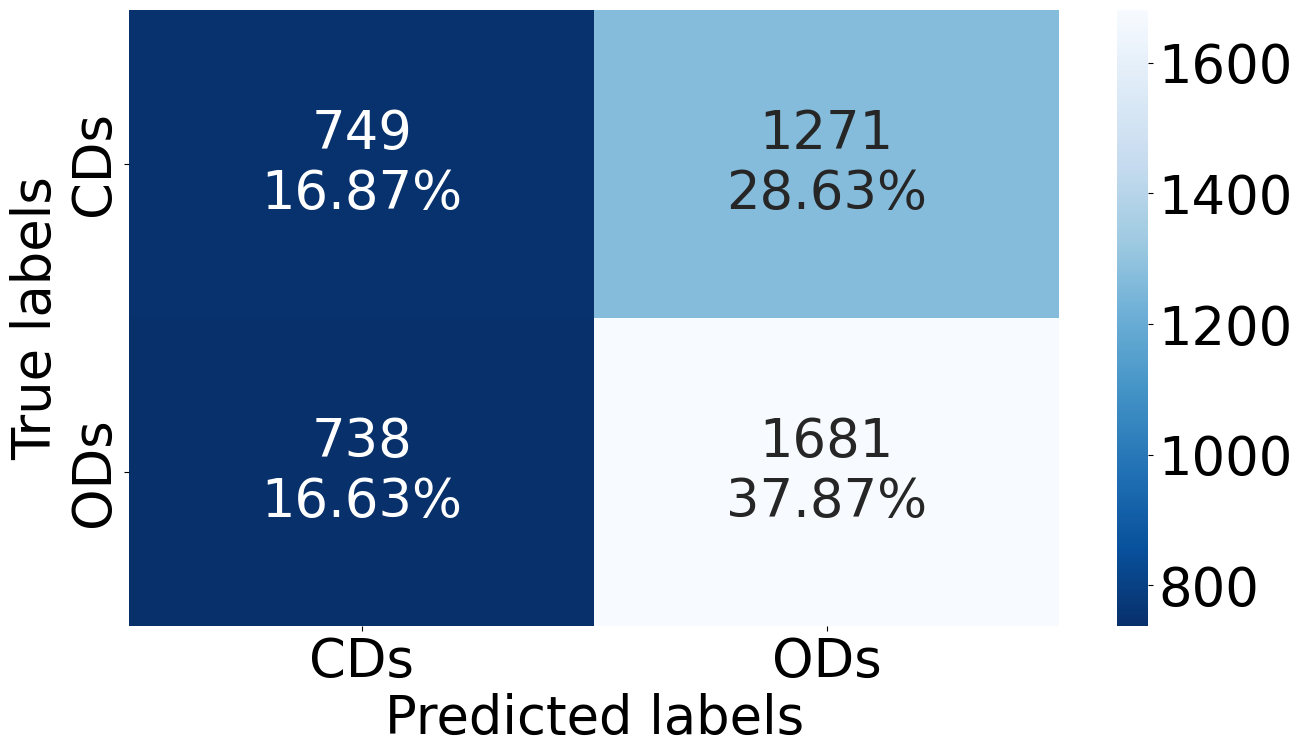

In [79]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Predicted labels')
# Texto do eixo y
ax.set_ylabel('True labels')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['CDs','ODs'])
ax.yaxis.set_ticklabels(['CDs','ODs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [80]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [81]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('DO e pertDO classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('DO classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('pertDO classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

DO e pertDO classificados corretamente: 2430
DO classificados corretamente(VP)     : 1681
pertDO classificados corretamente(FP) : 749


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [82]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [83]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 2009
DO classificados incorretamente(VN)     : 738
pertDO classificados incorretamente(FN) : 1271


#### Acurácia das listas

In [84]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  DO coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  pertDO incoerentes = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  DO incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  pertDO coerentes   = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 4439
  Total de documentos originais     : 2419
  Total de documentos perturbados   : 2020
Total de acertos                    : 2430
Total de erros                      : 2009

Acurácia                                        : 54.74%
  DO coerentes       = Verdadeiros positivos(VP): 37.87%
  pertDO incoerentes = Falsos positivos(FP)     : 16.87%
  DO incoerentes     = Verdadeiro negativos(VN) : 16.63%
  pertDO coerentes   = Falsos negativos(FN)     : 28.63%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [85]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 1681
Sem repetição: 1681


Criando dados indexados

In [86]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_12333_SENT_15440,1,1
SENT_377_SENT_1709,1,1
SENT_698_SENT_2030,1,1
SENT_1209_SENT_2541,1,1
SENT_10143_SENT_13250,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [87]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 738
Sem repetição: 738


Criando dados indexados

In [88]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_10423_SENT_13530,1,0
SENT_11061_SENT_14168,1,0
SENT_11971_SENT_15078,1,0
SENT_53_SENT_1385,1,0
SENT_1181_SENT_2513,1,0


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [89]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 749
Sem repetição: 749


Criando dados indexados

In [90]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_12485_SENT_15592,0,0
SENT_1330_SENT_2662,0,0
SENT_12116_SENT_15223,0,0
SENT_12569_SENT_15676,0,0
SENT_12589_SENT_15696,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [91]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 1271
Sem repetição: 1271


Criando dados indexados

In [92]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_12430_SENT_15537,0,1
SENT_568_SENT_1900,0,1
SENT_863_SENT_2195,0,1
SENT_1012_SENT_2344,0,1
SENT_1028_SENT_2360,0,1


Remove as duplicidades dos documentos classificados corretamente.

In [93]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 2430
Sem repetição: 2430


Criando dados indexados

In [94]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
2104,SENT_10497_SENT_13604,0,0
875,SENT_315_SENT_1647,1,1
1385,SENT_12347_SENT_15454,0,0
1862,SENT_11447_SENT_14554,1,1
301,SENT_38_SENT_1370,1,1


In [95]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_12333_SENT_15440,1,1
SENT_12485_SENT_15592,0,0
SENT_377_SENT_1709,1,1
SENT_698_SENT_2030,1,1
SENT_1209_SENT_2541,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [96]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 2009
Sem repetição: 2009


Criando dados indexados

In [97]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
SENT_12430_SENT_15537,0,1
SENT_568_SENT_1900,0,1
SENT_863_SENT_2195,0,1
SENT_1012_SENT_2344,0,1
SENT_1028_SENT_2360,0,1


### Medidas de DO e pertDO

#### Função quer realiza a medição dos documentos



##### getMedidasComparacaoPalavra

In [98]:
import sys

def getMedidasComparacaoPalavra(id_documento,
                                index_sentenca,
                                index_wi,
                                index_wj,
                                estrategia_medida=0):

  # Pesquisa a medida de comparação das palavras wi e wj
  # pelo id do documento, índice da sentença, índice da palavra wi e índice da palavra wj
  medidas = lista_comparacao_palavra_indexado.loc[str(id_documento),
                                                  index_sentenca,
                                                  index_wi,
                                                  index_wj]

  if len(medidas) != 0:
    # print(">>>>medidas:",medidas)
    # Seleciona a estratégia de pooling
    pooling = "_mean"
    if estrategia_medida == 1:
      pooling = "_max"

    cos = medidas["cos" + pooling]
    euc = medidas["euc" + pooling]
    man = medidas["man" + pooling]

    return cos, euc, man

  else:
   print("Problemas comparação palavras:", medidas)
   return 0, float(sys.maxsize), float(sys.maxsize)

##### Palavras Adjacentes

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras

In [99]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras(id_documento,
                                                                documento,
                                                                lista_sentenca_documento,
                                                                lista_tokens_documento,
                                                                lista_pos_documento,
                                                                estrategia_medida):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    #Percorre as palavras do documento
    for ix in range(0,k-1):

      # Seleciona as palavras do documento
      wi = sentenca_token[ix]
      wj = sentenca_token[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = sentenca_pos[ix]
      pos_j = sentenca_pos[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)

      # Recupera as medidas entre wi e wj
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as k-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:

      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord

In [100]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord(id_documento,
                                                              documento,
                                                              lista_sentenca_documento,
                                                              lista_tokens_documento,
                                                              lista_pos_documento,
                                                              estrategia_medida):

  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    #print("sentenca:",sentenca)
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    #Percorre as palavras do documento
    for ix in range(0,k-1):

      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      wj = lista_tokens_nova[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = lista_pos_nova[ix]
      pos_j = lista_pos_nova[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)

      # Recupera as medidas entre wi e wj
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes

In [101]:
def getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes(id_documento,
                                                                    documento,
                                                                    lista_sentenca_documento,
                                                                    lista_tokens_documento,
                                                                    lista_pos_documento,
                                                                    estrategia_medida,
                                                                    classe_saliente=["NOUN","VERB","AUX"]):

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Seleciona somente palavras saliente
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    #Percorre as palavras do documento
    for ix in range(0,k-1):

      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      wj = lista_tokens_nova[ix+1]
      # Seleciona as POS-Tagging das palavras
      pos_i = lista_pos_nova[ix]
      pos_j = lista_pos_nova[ix+1]

      # print("\nwi:", wi, ix)
      # print("wj:", wj, ix+1)

      # Recupera as medidas entre wi e wj
      cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, ix+1, estrategia_medida)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasAdjacentes

Recupera as medidas da coerência das palavras adjacentes de acordo com o filtro de palavras a ser utilizado nos documentos.

In [102]:
def getMedidasCoerenciaPalavrasAdjacentes(id_documento,
                                          documento,
                                          lista_sentenca_documento,
                                          lista_tokens_documento,
                                          lista_pos_documento,
                                          estrategia_medida = 0,
                                          filtro_palavra = 0,
                                          classe_saliente=["NOUN","VERB","AUX"]):

  """
    Recupera as medidas da coerência das palavras adjacentes de acordo com o filtro de palavras a ser utilizado nos documentos.
  """

  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasAdjacentesDocumentoTodasPalavras(id_documento,
                                                                       documento,
                                                                       lista_sentenca_documento,
                                                                       lista_tokens_documento,
                                                                       lista_pos_documento,
                                                                       estrategia_medida)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasAdjacentesDocumentoSemStopWord(id_documento,
                                                                         documento,
                                                                         lista_sentenca_documento,
                                                                         lista_tokens_documento,
                                                                         lista_pos_documento,
                                                                         estrategia_medida)
    else:
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos
          return getMedidasCoerenciaPalavrasAdjacentesDocumentoPalavrasSalientes(id_documento,
                                                                                 documento,
                                                                                 lista_sentenca_documento,
                                                                                 lista_tokens_documento,
                                                                                 lista_pos_documento,
                                                                                 estrategia_medida,
                                                                                 classe_saliente=classe_saliente)

##### Palavras Combinação

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras

In [103]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras(id_documento,
                                                                documento,
                                                                lista_sentenca_documento,
                                                                lista_tokens_documento,
                                                                lista_pos_documento,
                                                                estrategia_medida):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    contaComparacoes = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):

      # Seleciona as palavras do documento
      wi = sentenca_token[ix]
      pos_i = sentenca_pos[ix]

      # Percorre as palavras da sentença
      for jx in range(ix+1,k):

        # Seleciona as palavras do documento
        wj = sentenca_token[jx]
        pos_j = sentenca_pos[jx]

        # print("\nwi:", wi, pos_i)
        # print("wj:", wj, pos_j)

        # Recupera as medidas entre wi e wj
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)

        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man

        contaComparacoes = contaComparacoes + 1

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(contaComparacoes)
      MWeuc = float(soma_Weuc)/float(contaComparacoes)
      MWman = float(soma_Wman)/float(contaComparacoes)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord


In [104]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord(id_documento,
                                                              documento,
                                                              lista_sentenca_documento,
                                                              lista_tokens_documento,
                                                              lista_pos_documento,
                                                              estrategia_medida):

  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    #print("sentenca:",sentenca)
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):
      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      pos_i = lista_pos_nova[ix]

      # Percorre as palavras da sentença
      for jx in range(ix+1,k):
        # Seleciona as palavras do documento
        wj = lista_tokens_nova[jx]
        pos_j = lista_pos_nova[jx]

        # print("\nwi:", wi, pos_i)
        # print("wj:", wj, pos_j)

        # Recupera as medidas entre wi e wj
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)

        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  Scos = float(soma_Scos)/float(n)
  Seuc = float(soma_Seuc)/float(n)
  Sman = float(soma_Sman)/float(n)

  return Scos, Seuc, Sman

###### getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes

In [105]:
def getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes(id_documento,
                                                                    documento,
                                                                    lista_sentenca_documento,
                                                                    lista_tokens_documento,
                                                                    lista_pos_documento,
                                                                    estrategia_medida,
                                                                    classe_saliente=["NOUN","VERB","AUX"]):

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Somente palavras saliente
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

     # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k-1):
      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      pos_i = lista_pos_nova[ix]

      # Percorre as palavras da sentença
      for jx in range(ix+1,k):
        # Seleciona as palavras do documento
        wj = lista_tokens_nova[jx]
        pos_j = lista_pos_nova[jx]

        # print("\nwi:", wi, pos_i)
        # print("wj:", wj, pos_j)

        # Recupera as medidas entre wi e wj
        cos, euc, man = getMedidasComparacaoPalavra(id_documento, i, ix, jx, estrategia_medida)

        # Acumula as medidas do par de palavras
        soma_Wcos = soma_Wcos + abs(cos)
        soma_Weuc = soma_Weuc + euc
        soma_Wman = soma_Wman + man

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k-1) != 0:
      MWcos = float(soma_Wcos)/float(k-1)
      MWeuc = float(soma_Weuc)/float(k-1)
      MWman = float(soma_Wman)/float(k-1)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasCombinacao

Recupera as medidas da coerência da combinação de palavras de acordo com o filtro de palavras a ser utilizado nos documentos.

In [106]:
def getMedidasCoerenciaPalavrasCombinacao(id_documento,
                                          documento,
                                          lista_sentenca_documento,
                                          lista_tokens_documento,
                                          lista_pos_documento,
                                          estrategia_medida,
                                          filtro_palavra = 0,
                                          classe_saliente=["NOUN","VERB","AUX"]):
  """
    Recupera as medidas da coerência da combinação de palavras de acordo com o filtro de palavras a ser utilizado nos documentos.
  """

  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasCombinacaoDocumentoTodasPalavras(id_documento,
                                                                       documento,
                                                                       lista_sentenca_documento,
                                                                       lista_tokens_documento,
                                                                       lista_pos_documento,
                                                                       estrategia_medida)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasCombinacaoDocumentoSemStopWord(id_documento, documento,
                                                                         lista_sentenca_documento,
                                                                         lista_tokens_documento,
                                                                         lista_pos_documento,
                                                                         estrategia_medida)
    else:
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos
          return getMedidasCoerenciaPalavrasCombinacaoDocumentoPalavrasSalientes(id_documento,
                                                                                 documento,
                                                                                 lista_sentenca_documento,
                                                                                 lista_tokens_documento,
                                                                                 lista_pos_documento,
                                                                                 estrategia_medida,
                                                                                 classe_saliente=classe_saliente)

##### Contexto

###### getMedidasComparacaoPalavrasGlobal

In [107]:
import sys

def getMedidasComparacaoPalavrasGlobal(id_documento,
                                       index_sentenca,
                                       index_wi,
                                       estrategia_medida=0,
                                       filtro_palavra=0):

  # Pesquisa a medida palavra wi e o contexto
  # pelo id do documento, índice da sentença, índice da palavra wi
  medidas = lista_comparacao_contexto_indexado.loc[str(id_documento),
                                                   index_sentenca,
                                                   index_wi]

  if len(medidas) != 0:
    # print(">>>>medidas:",medidas)
    # Seleciona a estratégia de pooling
    pooling = "_mean"
    if estrategia_medida == 1:
      pooling = "_max"

    # Seleciona o filtro de palavra
    if filtro_palavra == 0: # Todas as palavras
      cos = medidas["cos_ctxall" + pooling]
      euc = medidas["euc_ctxall" + pooling]
      man = medidas["man_ctxall" + pooling]
    else:
      if filtro_palavra == 1: # Sem as stopwords
        cos = medidas["cos_ctxclean" + pooling]
        euc = medidas["euc_ctxclean" + pooling]
        man = medidas["man_ctxclean" + pooling]
      else:
        if filtro_palavra == 2: # Somente verbos, auxiliar e substantivo
          cos = medidas["cos_ctxverbnoun" + pooling]
          euc = medidas["euc_ctxverbnoun" + pooling]
          man = medidas["man_ctxverbnoun" + pooling]

    return cos, euc, man

  else:
    print("Problemas comparação contexto:", medidas)
    return 0, float(sys.maxsize), float(sys.maxsize)

###### getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras

In [108]:
def getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras(id_documento,
                                                            documento,
                                                            lista_sentenca_documento,
                                                            lista_tokens_documento,
                                                            lista_pos_documento,
                                                            estrategia_medida,
                                                            filtro_palavra):
  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Quantidade de palavras da sentença
    k = len(sentenca_token)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento
      wi = sentenca_token[ix]
      pos_i = sentenca_pos[ix]

      # print("\nwi:", wi, pos_i)

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento,
                                                         i,
                                                         ix,
                                                         estrategia_medida,
                                                         filtro_palavra)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord

In [109]:
def getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord(id_documento,
                                                          documento,
                                                          lista_sentenca_documento,
                                                          lista_tokens_documento,
                                                          lista_pos_documento,
                                                          estrategia_medida,
                                                          filtro_palavra):

  '''
    Percorre as sentenças de um documento para calcular as medidas
  '''

  #print("lista_sentenca_documento:", lista_sentenca_documento)
  #print("lista_tokens_documento:", lista_tokens_documento)
  #print("lista_pos_documento:", lista_pos_documento)

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    #print("sentenca:",sentenca)
    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    #print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    #print("sentenca_pos:",sentenca_pos)
    #print("Quantidade de palavras:",len(sentenca_token))

    # Seleciona as palavras e POS-Tagging sem as Stopwords
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, palavra in enumerate(sentenca_token):
        # Se o token estiver não lista de stopwords
        if palavra.lower() not in getStopwords(nlp):
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      pos_i = lista_pos_nova[ix]

      # print("\nwi:", wi, pos_i)

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento,
                                                         i,
                                                         ix,
                                                         estrategia_medida,
                                                         filtro_palavra)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  Scos = float(soma_Scos)/float(n)
  Seuc = float(soma_Seuc)/float(n)
  Sman = float(soma_Sman)/float(n)

  return Scos, Seuc, Sman

###### getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes

In [110]:
def getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes(id_documento,
                                                                documento,
                                                                lista_sentenca_documento,
                                                                lista_tokens_documento,
                                                                lista_pos_documento,
                                                                estrategia_medida,
                                                                filtro_palavra,
                                                                classe_saliente=["NOUN","VERB","AUX"]):

  # Acumuladores das medidas entre as sentenças
  soma_Scos = 0
  soma_Seuc = 0
  soma_Sman = 0

  # Quantidade de sentenças no documento
  n = len(lista_sentenca_documento)

  # Percorre as sentenças do documento
  for i, sentenca in enumerate(lista_sentenca_documento):

    # Carrega as POSTagging da sentença
    sentenca_token = lista_tokens_documento[i]
    # print("sentenca_token:",sentenca_token)
    sentenca_pos = lista_pos_documento[i]
    # print("sentenca_pos:",sentenca_pos)
    # print("Quantidade de palavras:",len(sentenca_token))

    # Somente palavras saliente
    lista_tokens_nova = []
    lista_pos_nova = []
    # Percorre as postagging das palavras
    for ix, pos in enumerate(sentenca_pos):
        # Se a postagging da palavra estiver na lista das classes das salientes
        if pos in classe_saliente:
          # Guarda os elementos utilizados
          lista_tokens_nova.append(sentenca_token[ix])
          lista_pos_nova.append(sentenca_pos[ix])

    #print("Depois")
    #print("lista_tokens_nova:",lista_tokens_nova)
    #print("POS Tagging:",lista_pos_nova)
    #print("Quantidade de palavras:",len(lista_tokens_nova))

    # Quantidade de palavras na sentença
    k = len(lista_tokens_nova)

    # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

     # Acumuladores das medidas entre as palavras
    soma_Wcos = 0
    soma_Weuc = 0
    soma_Wman = 0

    # Seleciona os pares de sentença a serem avaliados
    for ix in range(0,k):

      # Seleciona as palavras do documento
      wi = lista_tokens_nova[ix]
      pos_i = lista_pos_nova[ix]

      # print("\nwi:", wi, pos_i)

      # Recupera as medidas entre wi com o contexto
      cos, euc, man = getMedidasComparacaoPalavrasGlobal(id_documento,
                                                         i,
                                                         ix,
                                                         estrategia_medida,
                                                         filtro_palavra)

      # Acumula as medidas do par de palavras
      soma_Wcos = soma_Wcos + abs(cos)
      soma_Weuc = soma_Weuc + abs(euc)
      soma_Wman = soma_Wman + abs(man)

    # Calcula a média das medidas para as m-1 palavras da sentença
    MWcos = 0
    MWeuc = 0
    MWman = 0

    # Se existe palavras
    if float(k) != 0:
      MWcos = float(soma_Wcos)/float(k)
      MWeuc = float(soma_Weuc)/float(k)
      MWman = float(soma_Wman)/float(k)

    # Acumula a média das medidas das palavras da sentença
    soma_Scos = soma_Scos + MWcos
    soma_Seuc = soma_Seuc + MWeuc
    soma_Sman = soma_Sman + MWman

    del lista_tokens_nova
    del lista_pos_nova

  # Calcula a média das medidas para o documento
  MScos = float(soma_Scos)/float(n)
  MSeuc = float(soma_Seuc)/float(n)
  MSman = float(soma_Sman)/float(n)

  return MScos, MSeuc, MSman

###### getMedidasCoerenciaPalavrasGlobal

Recupera as medidas da palavra com o contexto global de acordo com o filtro de palavras a ser utilizado nos documentos.



In [111]:
def getMedidasCoerenciaPalavrasGlobal(id_documento,
                                      documento,
                                      lista_sentenca_documento,
                                      lista_tokens_documento,
                                      lista_pos_documento,
                                      estrategia_medida,
                                      filtro_palavra = 0,
                                      classe_saliente=["NOUN","VERB","AUX"]):

  """
    Recupera as medidas da palavra com o contexto global de acordo com o filtro de palavras a ser utilizado nos documentos.
  """

  if filtro_palavra == 0: # Todas as palavras
    return getMedidasCoerenciaPalavrasGlobalDocumentoTodasPalavras(id_documento,
                                                                   documento,
                                                                   lista_sentenca_documento,
                                                                   lista_tokens_documento,
                                                                   lista_pos_documento,
                                                                   estrategia_medida,
                                                                   filtro_palavra)
  else:
    if filtro_palavra == 1: # Sem stopwords
        return getMedidasCoerenciaPalavrasGlobalDocumentoSemStopWord(id_documento, documento,
                                                                     lista_sentenca_documento,
                                                                     lista_tokens_documento,
                                                                     lista_pos_documento,
                                                                     estrategia_medida,
                                                                     filtro_palavra)
    else:
        if filtro_palavra == 2: # Somente verbos(e auxiliares) substantivos
          return getMedidasCoerenciaPalavrasGlobalDocumentoPalavrasSalientes(id_documento,
                                                                             documento,
                                                                             lista_sentenca_documento,
                                                                             lista_tokens_documento,
                                                                             lista_pos_documento,
                                                                             estrategia_medida,
                                                                             filtro_palavra,
                                                                             classe_saliente=classe_saliente)

###### getMedidasCoerenciaDocumento

Recupera as medidas de coerência de acordo com a equação a ser utilizado nos documentos.

In [112]:
def getMedidasCoerenciaDocumento(id_documento,
                                 documento,
                                 lista_sentenca_documento,
                                 lista_tokens_documento,
                                 lista_pos_documento,
                                 equacao_medida = 0,
                                 estrategia_medida = 0,
                                 filtro_palavra = 0,
                                 classe_saliente=["NOUN","VERB","AUX"]):

  """
    Recupera as medidas de coerência de acordo com a equação a ser utilizado nos documentos.
  """

  if equacao_medida == 0: # Compara palavras adjacentes
    # print("Calculando para palavra adjacentes")
    return getMedidasCoerenciaPalavrasAdjacentes(id_documento,
                                                 documento,
                                                 lista_sentenca_documento,
                                                 lista_tokens_documento,
                                                 lista_pos_documento,
                                                 estrategia_medida,
                                                 filtro_palavra,
                                                 classe_saliente=classe_saliente)
  else:
    if equacao_medida == 1: # Compara todas as palavras
        # print("Calculando para todas as palavras")
        return getMedidasCoerenciaPalavrasCombinacao(id_documento,
                                                     documento,
                                                     lista_sentenca_documento,
                                                     lista_tokens_documento,
                                                     lista_pos_documento,
                                                     estrategia_medida,
                                                     filtro_palavra,
                                                     classe_saliente=classe_saliente)
    else:
        if equacao_medida == 2: # Somente verbos(e auxiliares) substantivos
          # print("Calculando para o contexto")
          return getMedidasCoerenciaPalavrasGlobal(id_documento,
                                                   documento,
                                                   lista_sentenca_documento,
                                                   lista_tokens_documento,
                                                   lista_pos_documento,
                                                   estrategia_medida,
                                                   filtro_palavra,
                                                   classe_saliente=classe_saliente)

##### Auxiliares

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [113]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.

    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.

    Retorno:
      `documento_original` - Um texto com o documento.
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.

  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]

    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal
    lista_sentenca_documento_original = reg_documento_original["sentencas"]
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]

    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("reg_original_pos:",reg_original_pos)
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])

    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getMedidasCoerenciaDocumentoId

In [114]:
def getMedidasCoerenciaDocumentoId(id_documento,
                                   equacao_medida = 0,
                                   estrategia_medida = 0,
                                   filtro_palavra = 0):
  """
    Recupera as medidas das equações de documento original ou perturbado.

    Parâmetros:
      `id_documento` - Um id de documento original o perturbado.
      `equacao_medida` - Um id equação de medida (0 - CAW, 1 - CWP, 2 - CG).
      `estrategia_medida` - Um id de estratégia de medida (0 - MEAN, 1 - MAX).
      `filtro_palavra` - Um id de filtro de palavra (0 - ALL, 1 - CLEAN, 2 - REL).

    Retorno:
      `medida_cos` - A medida do documento segundo os parâmetros usando similaridade do cosseno.
      `medida_euc` - A medida do documento segundo os parâmetros usando distância Euclidiana.
      `medida_man` - A medida do documento segundo os parâmetros usando distância de Manhattan.

  """

  # Localiza os dados do documento
  documento, lista_sentenca_documento, lista_tokens_documento, lista_pos_documento = getDadosDocumento(id_documento)

  # Retorna as medidas de acorrdo com os parâmetros
  return getMedidasCoerenciaDocumento(id_documento,
                                 documento,
                                 lista_sentenca_documento,
                                 lista_tokens_documento,
                                 lista_pos_documento,
                                 equacao_medida = equacao_medida,
                                 estrategia_medida = estrategia_medida,
                                 filtro_palavra = filtro_palavra)

###### getDadosPerturbacao

In [115]:
def getDadosPerturbacao(_id_perturbado):

  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3]

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [116]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = ""
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)

  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]

  return pos_token_procura

###### getIndicePalavraMascarada

In [117]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1

  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i

  return indice_token_procura

###### trataNumero

In [118]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### getLinhaMedida

In [119]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):

  linha = str(x[1]
              + " ["
              + x[2]
              + "("
              + melhorDO
              + trataNumero(x[indice_palavra_selecionada])
              + ") -> "
              + x[4]
              + "("
              + melhor_pertDO
              + trataNumero(x[indice_palavra_substituida])
              + ")"
              + " - "
              + trataNumero(x[6])
              + "] - "
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [120]:
def getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):

  linha = str(x[1] +
              " [" +
              x[2] +
              "(" +
              melhorDO +
              trataNumero(x[indice_palavra_selecionada]) +
              ") -> " +
              x[4] +
              "(" +
              melhor_pertDO +
              trataNumero(x[indice_palavra_substituida]) +
              ")" +
              " - " +
              trataNumero(x[6]) +
              "] - " +
              str(x[7]) +
              " - " +
              x[3] +
              "/" +
              x[5])
  return linha

In [121]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

In [122]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

In [123]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CPW - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None

In [124]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CPW"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None

#### Função gera as medidas das palavras entre DO e pertDO usando a equação CG

Compara a palavra com a medida global(CG) de DO as versões de pertDO.

In [125]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasPerturbadoCG(_id_documento_original,
                              estrategia_medida = 0,
                              filtro_palavra = 0):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Recupera o id do documento original
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Verifica se o documento original foi classificado corretamente
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if documento_id_original == True:
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      # Guarda o maior ranking
      maior_ranking = 0

      # Lista dos documentos perturbados classificados
      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        # Não realiza nenhum tipo de filtragem
        cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                        index_sentenca,
                                                                                        index_wi,
                                                                                        estrategia_medida, #Estratégia 0 = MEAN
                                                                                        filtro_palavra) #Filtro palavra 0 = All
        #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                        index_sentenca,
                                                                                        index_wi,
                                                                                        estrategia_medida, #Estratégia 0 = MEAN
                                                                                        filtro_palavra) #Filtro palavra 0 = All
        # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)

        # Localiza a classificação do documento perturbado
        classe = 1
        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:
          classe = 0
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)

        if j == 0:
          maior_ranking = peso_predito
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_ctxall_DO,                          #8
                                              euc_ctxall_DO,                          #9
                                              man_ctxall_DO,                          #10
                                              cos_ctxall_pertDO,                      #11
                                              euc_ctxall_pertDO,                      #12
                                              man_ctxall_pertDO,                      #13
                                              ])

      # Calcula os percentuais das medidas do documento perturbado
      for i, x in enumerate(lista_perturbado_classificado):
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if x[8] != 0:
          dcos = (x[11]-x[8])/x[8] * 10
        else:
          dcos = x[11] * 10
        if x[9] != 0:
          deuc = (x[9]-x[12])/x[9]
        else:
          deuc = -x[12]
        if x[10] != 0:
          dman = (x[10]-x[13])/x[10]
        else:
          dman = -x[13]

        # POS Tagging iguais entre selecionada e perturbada
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0

        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1

        # Guarda a medida calculada do documento
        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    dcos,                #15
                                                    deuc,                #16
                                                    dman,                #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função gera as medidas de uma equação entre DO e pertDO

Gera todas as medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [126]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasEquacaoPerturbado(_id_documento_original,
                                      equacao_medida = 0,
                                      estrategia_medida = 0,
                                      filtro_palavra = 0,):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Recupera o id do documento original
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Verifica se o documento original foi classificado corretamente
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if documento_id_original == True:
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      maior_ranking = 0

      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        cos_DO, euc_DO, man_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        #print("     DO     :", palavra_mascarada, " - ", cos_DO, euc_DO, man_DO)


        cos_pertDO, euc_pertDO, man_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado,
                                                              lista_sentenca_documento_perturbado,
                                                              documento_perturbado_tokens,
                                                              documento_perturbado_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        # print("    pertDO :", token_predito, " - ", cos_pertDO, euc_pertDO, man_pertDO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)
        #print("verifica:", id_perturbado in lista_retorno_classificado_corretamente_sem_repeticao.index)

        # Localiza a classificação do documento perturbado
        classe = 1
        # Se foi encontrado foi classificado corretamente
        #if documento_id_perturbado_correto == True:
        if len(documento_id_perturbado_correto) != 0:
          classe = 0
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)

        if j == 0:
          maior_ranking = peso_predito
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_DO,                                 #8
                                              euc_DO,                                 #9
                                              man_DO,                                 #10
                                              cos_pertDO,                             #11
                                              euc_pertDO,                             #12
                                              man_pertDO,                             #13
                                              ])

      # Calcula os percentuais das medidas do documento perturbado
      for i, x in enumerate(lista_perturbado_classificado):
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if x[8] != 0:
          dcos = (x[11]-x[8])/x[8] * 10
        else:
          dcos = x[11] * 10
        if x[9] != 0:
          deuc = (x[9]-x[12])/x[9]
        else:
          deuc = -x[12]
        if x[10] != 0:
          dman = (x[10]-x[13])/x[10]
        else:
          dman = -x[13]

        # POS Tagging iguais entre selecionada e perturbada
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0

        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1

        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    dcos,                #15
                                                    deuc,                #16
                                                    dman,                #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função gera as medidas das equações entre DO e pertDO

Gera todas as medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [127]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def getListaMedidasEquacoesPerturbado(_id_documento_original,
                                      medida = 'cos',
                                      estrategia_medida = 0,
                                      filtro_palavra = 0,):

  lista_perturbado_classificado_medida = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Recupera o id do documento ooriginal
    id_documento_original = linha['id']

    if id_documento_original == _id_documento_original:

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(_id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Verifica se o documento original foi classificado corretamente
      documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if documento_id_original == True:
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      maior_ranking = 0

      lista_perturbado_classificado = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


        CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado,
                                                              lista_sentenca_documento_perturbado,
                                                              documento_perturbado_tokens,
                                                              documento_perturbado_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


        CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = 1, #CWP
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


        CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado,
                                                              lista_sentenca_documento_perturbado,
                                                              documento_perturbado_tokens,
                                                              documento_perturbado_pos,
                                                              equacao_medida = 1, #CWP
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


        CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = 2, #CG
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


        CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado,
                                                              lista_sentenca_documento_perturbado,
                                                              documento_perturbado_tokens,
                                                              documento_perturbado_pos,
                                                              equacao_medida = 2, #CG
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
        # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

        if medida == 'cos':
          CAW_DO = CAWcos_DO
          CWP_DO = CWPcos_DO
          CG_DO = CGcos_DO
          CAW_pertDO = CAWcos_pertDO
          CWP_pertDO = CWPcos_pertDO
          CG_pertDO = CGcos_pertDO
        else:
          if medida == 'euc':
            CAW_DO = CAWeuc_DO
            CWP_DO = CWPeuc_DO
            CG_DO = CGeuc_DO
            CAW_pertDO = CAWeuc_pertDO
            CWP_pertDO = CWPeuc_pertDO
            CG_pertDO = CGeuc_pertDO
          else:
             if medida == 'man':
              CAW_DO = CAWman_DO
              CWP_DO = CWPman_DO
              CG_DO = CGman_DO
              CAW_pertDO = CAWman_pertDO
              CWP_pertDO = CWPman_pertDO
              CG_pertDO = CGman_pertDO


        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
        #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)

        # Localiza a classificação do documento perturbado
        classe = 1
        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:
          classe = 0
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)

        if j == 0:
          maior_ranking = peso_predito
        else:
          if peso_predito > maior_ranking:
            maior_ranking = peso_predito

        # Guarda os dados
        lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              CAW_DO,                                 #8
                                              CWP_DO,                                 #9
                                              CG_DO,                                  #10
                                              CAW_pertDO,                             #11
                                              CWP_pertDO,                             #12
                                              CG_pertDO,                              #13
                                              ])

      # Calcula as medidas do documento perturbado
      for i, x in enumerate(lista_perturbado_classificado):
        # print("x:",x)
        ranking_percentual = x[6] / maior_ranking
        # calcula as diferenças
        if medida == 'cos':
          CAW = (x[11]-x[8])/x[8]
          CWP = (x[12]-x[9])/x[9]
          CG = (x[13]-x[10])/x[10]
        else:
          CAW = (x[8]-x[11])/x[8]
          CWP = (x[9]-x[12])/x[9]
          CG = (x[10]-x[13])/x[10]

        # POS Tagging iguais entre selecionada e perturbada
        pos_igual = 1
        if x[3] == x[5]:
          pos_igual = 0

        # Verifica se as palavras são iguais
        palavra_igual = 0
        if x[2] == x[4]:
          palavra_igual = 1

        lista_perturbado_classificado_medida.append([x[0],
                                                    x[1],
                                                    x[2],
                                                    x[3],
                                                    x[4],
                                                    x[5],
                                                    x[6],
                                                    x[7],
                                                    x[8],
                                                    x[9],
                                                    x[10],
                                                    x[11],
                                                    x[12],
                                                    x[13],
                                                    ranking_percentual,  #14
                                                    CAW,                 #15
                                                    CWP,                 #16
                                                    CG,                  #17
                                                    pos_igual,           #18
                                                    palavra_igual])      #19

  # Ordena a lista das medidas pela plausabilidade
  lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

  print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

  return lista_perturbado_classificado_medida

#### Função de visualização das medidas das palavras entre DO e pertDO usando a equação CG

Visualização das medidas da palavra com a medida global(CG) de DO as versões de pertDO.

In [128]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasCG(_id_documento_original,
                     medida = 'cos',
                     estrategia_medida = 0,
                     filtro_palavra = 0,
                     _exibir_dados = True):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos se o Id igual a None
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])
      else:
        classe = "0"

      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)

      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                           index_sentenca,
                                                                                           index_wi,
                                                                                           estrategia_medida = estrategia_medida, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = filtro_palavra) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                           index_sentenca,
                                                                                           index_wi,
                                                                                           estrategia_medida = estrategia_medida, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = filtro_palavra) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado corretamente
          if len(documento_id_perturbado_correto) != 0:

            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          cos_ctxall_DO,                          #8
                                                          euc_ctxall_DO,                          #9
                                                          man_ctxall_DO,                          #10
                                                          cos_ctxall_pertDO,                      #11
                                                          euc_ctxall_pertDO,                      #12
                                                          man_ctxall_pertDO,                      #13
                                                          ])

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

            # Se foi encontrado foi classificado incorretamente
            if len(documento_id_perturbado_incorreto) != 0:
              #print("documento_id_perturbado_incorreto:",len(documento_id_perturbado_incorreto))
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              cos_ctxall_DO,                          #8
                                                              euc_ctxall_DO,                          #9
                                                              man_ctxall_DO,                          #10
                                                              cos_ctxall_pertDO,                      #11
                                                              euc_ctxall_pertDO,                      #12
                                                              man_ctxall_pertDO,                      #13
                                                              ])

      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # Cosseno
      if medida == 'cos':
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:
        # Euclidiana
        if medida == 'euc':
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:
          # Manhatan
          if medida == 'man':
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      if exibir_dados == True:
        # Mostra a saída das classificações
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1

          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
          else:
            # distância euclidiana(busca a menor distância)
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))

      if len(lista_perturbado_classificado_incorreto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            else:
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            if exibir_dados == True:
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

In [129]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidas1(_id_documento_original,
                     medida = 'cos',
                     estrategia_medida = 0,
                     filtro_palavra = 0,
                     _exibir_dados = True):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos se o Id igual a None
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])
      else:
        classe = "0"

      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)

      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                           index_sentenca,
                                                                                           index_wi,
                                                                                           estrategia_medida = 0, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = 0) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                           index_sentenca,
                                                                                           index_wi,
                                                                                           estrategia_medida = 0, #Estratégia 0 = MEAN, 1 - MAX
                                                                                           filtro_palavra = 0) #Filtro palavra 0 = All, 1 - CLEAN, 2 - REL
          # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado corretamente
          if len(documento_id_perturbado_correto) != 0:

            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          cos_ctxall_DO,                          #8
                                                          euc_ctxall_DO,                          #9
                                                          man_ctxall_DO,                          #10
                                                          cos_ctxall_pertDO,                      #11
                                                          euc_ctxall_pertDO,                      #12
                                                          man_ctxall_pertDO,                      #13
                                                          ])

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

            # Se foi encontrado foi classificado incorretamente
            if len(documento_id_perturbado_incorreto) != 0:
              #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              cos_ctxall_DO,                          #8
                                                              euc_ctxall_DO,                          #9
                                                              man_ctxall_DO,                          #10
                                                              cos_ctxall_pertDO,                      #11
                                                              euc_ctxall_pertDO,                      #12
                                                              man_ctxall_pertDO,                      #13
                                                              ])

      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # Cosseno
      if medida == 'cos':
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:
        # Euclidiana
        if medida == 'euc':
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:
          # Manhatan
          if medida == 'man':
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      if exibir_dados == True:
        # Mostra a saída das classificações
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1

          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)
          else:
            # distância euclidiana(busca a menor distância)
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)
            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))

      if len(lista_perturbado_classificado_incorreto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            else:
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            if exibir_dados == True:
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

In [130]:
visualizaMedidasCG("1")

Documentos originais e perturados e suas classificações: 4439
  Classificados corretamente(classe=previsão): 2430
  Classificados incorretamente(classe!=previsão): 2009
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos: 0 documento [00:00, ? documento/s]

#### Função de visualização das medidas de uma equação entre DO e pertDO

Visualização das medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [131]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'cos',
                             estrategia_medida = 0,
                             filtro_palavra = 0,
                             _exibir_dados = True):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])
      else:
        classe = "0"

      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)

      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 0, #CAW
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original,
                                                                lista_sentenca_documento_original,
                                                                documento_original_tokens,
                                                                documento_original_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original,
                                                                lista_sentenca_documento_original,
                                                                documento_original_tokens,
                                                                documento_original_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado corretamente
          #if documento_id_perturbado_correto == True:
          if len(documento_id_perturbado_correto) != 0:

            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ])

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

            # Se foi encontrado foi classificado incorretamente
            if len(documento_id_perturbado_incorreto) != 0:
              #print("documento_id_perturbado_incorreto:",len(documento_id_perturbado_incorreto))
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              CAW_DO,                                 #8
                                                              CWP_DO,                                 #9
                                                              CG_DO,                                  #10
                                                              CAW_pertDO,                             #11
                                                              CWP_pertDO,                             #12
                                                              CG_pertDO,                              #13
                                                              ])

      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:
        # CWP
        if equacao_medida == 1:
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      if exibir_dados == True:
        # Mostra a saída das classificações
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1

          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)

            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          else:
            # distância euclidiana(busca a menor distância)
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)

            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))

      if len(lista_perturbado_classificado_incorreto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            else:
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            if exibir_dados == True:
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

#### Função de visualização das medidas das equações entre DO e pertD

Visualização das medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [132]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoes(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0,
                             _exibir_dados = True):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  exibir_dados = _exibir_dados

  lista_melhor_DO_correto = []
  lista_melhor_pertDO_correto = []
  lista_melhor_DO_incorreto = []
  lista_melhor_pertDO_incorreto = []

  # Lista as medidas de um documento ou de todos
  if _id_documento_original == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == linha['id']]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        #print("documento:",documento)
        classe =  str(documento['classe'].values[0])
      else:
        classe = "0"

      if exibir_dados == True:
        #Mostra o documento original e sua classificação
        print("\nDO: " + linha["documento"] + " - " + classe)
        pos_concatenado = ""
        # Concatena as pos do documento
        for doc_pos1 in documento_original_pos:
            # print("doc_pos1",doc_pos1)
            for doc_pos2 in doc_pos1:
              pos_concatenado = pos_concatenado + doc_pos2 + " "
        print("    " + " " + pos_concatenado)

      # Lista com documentos perturbados e sua classificacao para o DO
      lista_perturbado_classificado_correto = []
      lista_perturbado_classificado_incorreto = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = linha['id'] + 1
          #print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = 0, #CAW
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)


          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 0, #CAW
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)


          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original,
                                                                lista_sentenca_documento_original,
                                                                documento_original_tokens,
                                                                documento_original_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)


          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 1, #CWP
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)


          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                                documento_original,
                                                                lista_sentenca_documento_original,
                                                                documento_original_tokens,
                                                                documento_original_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          #print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)


          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                                documento_perturbado,
                                                                lista_sentenca_documento_perturbado,
                                                                documento_perturbado_tokens,
                                                                documento_perturbado_pos,
                                                                equacao_medida = 2, #CG
                                                                estrategia_medida = estrategia_medida,
                                                                filtro_palavra = filtro_palavra)
          # print("    pertDO :", token_predito, " - ", CGcos_pertDO, CGeuc_pertDO, CGman_pertDO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          # Recupera o id documento perturbado se ele foi classificado corretamente
          documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado corretamente
          #if documento_id_perturbado_correto == True:
          if len(documento_id_perturbado_correto) != 0:

            versaoPerturbadaClassificada = True
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
            #print("documento:",documento)
            lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          str(documento["documento"]),            #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ])

          else:
            # Recupera o id documento perturbado se ele foi classificado incorretamente
            documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

            # Se foi encontrado foi classificado incorretamente
            if len(documento_id_perturbado_incorreto) != 0:
              #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
              documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
              #print("documento:",documento)
              lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                              str(documento["documento"]),  #1
                                                              palavra_mascarada,                      #2
                                                              palavra_mascarada_classe,               #3
                                                              token_predito,                          #4
                                                              token_predito_classe,                   #5
                                                              peso_predito,                           #6
                                                              1,                                      #7
                                                              CAW_DO,                                 #8
                                                              CWP_DO,                                 #9
                                                              CG_DO,                                  #10
                                                              CAW_pertDO,                             #11
                                                              CWP_pertDO,                             #12
                                                              CG_pertDO,                              #13
                                                              ])

      # Ordena as listas
      lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
      lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      else:
        # CWP
        if equacao_medida == 1:
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
        else:
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      if exibir_dados == True:
        # Mostra a saída das classificações
        print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

      if len(lista_perturbado_classificado_correto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_correto):
          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais + 1

          # similaridade do cosseno euclidiana(busca a maior distância)
          if medida == 'cos':
            if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)

            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          else:
            # distância euclidiana(busca a menor distância)
            if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
              # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
              melhorDO = ">"
              melhor_pertDO = ""
              conta_melhor_DO = conta_melhor_DO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_DO_correto.append(linha)

            else:
              # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
              melhorDO = ""
              melhor_pertDO = ">"
              conta_melhor_pertDO = conta_melhor_pertDO + 1
              linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              lista_melhor_pertDO_correto.append(linha)

          if exibir_dados == True:
            linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

      if exibir_dados == True:
        print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))

      if len(lista_perturbado_classificado_incorreto) != 0:
        conta_melhor_DO = 0
        conta_melhor_pertDO = 0
        classes_iguais = 0

        for i, x in enumerate(lista_perturbado_classificado_incorreto):

            # Classes morfosintáticas iguais
            if x[3] == x[5]:
              classes_iguais = classes_iguais  + 1

            if medida == 'cos':
              if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            else:
              if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
                # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
                melhorDO = ">"
                melhor_pertDO = ""
                conta_melhor_DO = conta_melhor_DO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_DO_incorreto.append(linha)

              else:
                # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
                melhorDO = ""
                melhor_pertDO = ">"
                conta_melhor_pertDO = conta_melhor_pertDO + 1
                linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
                lista_melhor_pertDO_incorreto.append(linha)

            if exibir_dados == True:
              linha = getLinhaMedidaExibicao(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
              print("  " + str(i+1), "-" + linha)

        if exibir_dados == True:
          print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
          print("       Classes iguais :",classes_iguais)

#### Função que mostra os dados das medidas das palavras entre DO e pertDO usando a equação CG


Gera CSV das medidas da palavra com a medida global(CG) de DO as versões de pertDO.

In [133]:
def mostrarMedidasCSV(lista_perturbado_classificado_medida,
                      _id_documento):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:
    # Procura um documento específico
    #if id != none and id in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      print("\nDO;classificacao(1-DO, 0-pertDO)")
      print(linha["documento"] + ";" + classe)
      # Concatena as pos do documento
      pos_concatenado = ""
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()

      # Cabeçalho dos documentos perturbados
      print("pertDO;" +                                   #0
            "classificacao(1-DO,0-pertDO);" +             #1
            "palavra selecionada;" +                      #2
            "classe palavra selecionada;" +               #3
            "CGcos(selecionada,DO);" +                    #4
            "CGeuc(selecionada,DO);" +                    #5
            "CGman(selecionada,DO);" +                    #6
            "palavra perturbada;" +                       #7
            "classe palavra perturbada;" +                #8
            "CGcos(perturbada, pertDO);" +                #9
            "CGeuc(perturbada, pertDO);" +                #10
            "CGman(perturbada, pertDO);"+                 #11
            "ranking de plausabilidade;" +                #12
            "dcos;" +                                     #13
            "deuc;" +                                     #14
            "dman;" +                                     #15
            "posigual;" +                                 #16
            "palavra_igual")                              #17

      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):
        if  x[0].startswith(id_perturbado_parcial):
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11
                trataNumero(x[14]),";", #12
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                )
          conta = conta + 1
      print("Documentos perturbados:", conta)

#### Função que mostra os dados das medidas de uma equação das perturbações em CSV

Visualização das medidas usando medidas de distância e similaridade(cos,euc,man) de DO as versões de pertDO.

In [134]:
def mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida,
                             _id_documento,
                             equacao_medida = 0):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))

  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:
    # Procura um documento específico
    #if id != none and id in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      print("\nDO;classificacao(1-DO, 0-pertDO)")
      print(linha["documento"] + ";" + classe)
      # Concatena as pos do documento
      pos_concatenado = ""
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()

      eq = getEquacaoMedidaStrCurto(equacao_medida)
      # Cabeçalho dos documentos perturbados
      print("pertDO;" +                                   #0
            "classificacao(1-DO,0-pertDO);" +   #1
            "palavra selecionada;" +                      #2
            "classe palavra selecionada;" +               #3
            eq + "cos(selecionada,DO);" +                 #4
            eq + "euc(selecionada,DO);" +                 #5
            eq + "man(selecionada,DO);" +                 #6
            "palavra perturbada;" +                       #7
            "classe palavra perturbada;" +                #8
            eq + "cos(perturbada, pertDO);" +             #9
            eq + "euc(perturbada, pertDO);" +             #10
            eq + "man(perturbada, pertDO);"+              #11
            "ranking de plausabilidade;" +                #12
            eq + "dcos;" +                                #13
            eq + "deuc;" +                                #14
            eq + "dman;" +                                #15
            "posigual;" +                                 #16
            "palavra_igual")                              #17

      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):
        if  x[0].startswith(id_perturbado_parcial):
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11
                trataNumero(x[14]),";", #12
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                )
          conta = conta + 1
      print("Documentos perturbados:", conta)

#### Função que mostra os dados das medidas das equações dos documento perturbados em CSV

Visualização das medidas das equações de (in)coerrência(CAW,CWP,CG) de DO as versões de pertDO.

In [135]:
def mostrarMedidasEquacoesCSV(lista_perturbado_classificado_medida,
                             _id_documento,
                             medida = 'euc'):

  print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
  print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
  print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
  print("Medida           :", medida)

  # Lista as medidas de um documento ou de todos
  if _id_documento == None:
    lista_documentos = lista_documentos_originais
    #print("Todos")
  else:
    #print("Somente o id = ", id)
    lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento]

  # Percorre a lista dos documentos originais
  for i, linha in lista_documentos.iterrows():

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:
    # Procura um documento específico
    #if id != none and id in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = str(linha['id'])

      # print("id_documento_original:",id_documento_original)
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))

      # Recupera o documento original se ele foi classificado corretamente
      documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
      #print("documento_id_original:", documento_id_original)

      # Recupera a classificação do original
      classe = ""
      # Se o documento original foi encontrado foi classificado corretamente
      if len(documento_id_original) != 0:
        #print("documento_id_original:",len(documento_id_original))
        #documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_original['id'].values[0])]
        documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
        #print("documento:",documento)
        classe =  str(documento['classe'])
      else:
        classe = "0"

      print("\nDO;classificacao(1-DO, 0-pertDO)")
      print(linha["documento"] + ";" + classe)
      # Concatena as pos do documento
      pos_concatenado = ""
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print(pos_concatenado)
      print()

      # Cabeçalho dos documentos perturbados
      print("pertDO;" +                                     #0
            "classificacao(1-DO,0-pertDO);" +               #1
            "palavra selecionada;" +                        #2
            "classe palavra selecionada;" +                 #3
            "CAW" + medida + "(selecionada,DO);" +          #4
            "CWP" + medida + "(selecionada,DO);" +          #5
            "CG"  + medida + "(selecionada,DO);" +          #6
            "palavra perturbada;" +                         #7
            "classe palavra perturbada;" +                  #8
            "CAW" + medida + "(perturbada, pertDO);" +      #9
            "CWP" + medida + "(perturbada, pertDO);" +      #10
            "CG"  + medida + "(perturbada, pertDO);"+       #11
            "ranking de plausabilidade;" +                  #12
            "CAWd" + medida + ";" +                         #13
            "CWP"  + medida + ";" +                         #14
            "CGd"  + medida + ";"+                          #15
            "posigual;" +                                   #16
            "palavra_igual")                                #17

      # Id do documento perturbado
      id_perturbado_parcial = id_documento_original + "_pert_"
      #print("id_perturbado_parcial:",id_perturbado_parcial)

      conta = 0
      # Percorre os documentos perturbados e suas classificações a partir do original
      for i, x in enumerate(lista_perturbado_classificado_medida):
        if  x[0].startswith(id_perturbado_parcial):
          print(x[1],";",               #0
                x[7],";",               #1
                x[2],";",               #2
                x[3],";",               #3
                trataNumero(x[8]),";",  #4
                trataNumero(x[9]),";",  #5
                trataNumero(x[10]),";", #6
                x[4],";",               #7
                x[5],";",               #8
                trataNumero(x[11]),";", #9
                trataNumero(x[12]),";", #10
                trataNumero(x[13]),";", #11
                trataNumero(x[14]),";", #12
                trataNumero(x[15]),";", #13
                trataNumero(x[16]),";", #14
                trataNumero(x[17]),";", #15
                trataNumero(x[18]),";", #16
                trataNumero(x[19])      #17
                )
          conta = conta + 1
      print("Documentos perturbados:", conta)

#### Funções de gráfico das diferenças de um DO e suas perturbações classificadas

In [136]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 18
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2) # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

In [137]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def graficoMedidaPerturbado(lista_perturbado_classificado_medida,
                            _id_documento):
  # Dados do gráfico
  lista = [x for x in lista_perturbado_classificado_medida if x[0].startswith(str(_id_documento)+"_pert_")]

  # Recupera o documento original
  documentos_original = lista_documentos_originais_indexado.loc[_id_documento]
  print("DO:",documentos_original[1])

  lista_ranking = [x[14]*100 for x in lista]
  lista_dcos = [x[15]*50 for x in lista]
  lista_deuc = [x[16]*100 for x in lista]
  lista_dman = [x[17]*100 for x in lista]
  lista_pos_igual = [x[18]*100 for x in lista]
  lista_classe = [x[7]*100 for x in lista]

  # Eixo x e y de Pertubado
  eixo_x1 = list(range(1, len(lista_ranking)+1))
  eixo_y1 = lista_ranking

  # Eixo x e y de Pertubado
  eixo_x2 = list(range(1, len(lista_dcos)+1))
  eixo_y2 = lista_dcos

  # Eixo x e y de Pertubado
  eixo_x3 = list(range(1, len(lista_deuc)+1))
  eixo_y3 = lista_deuc

  # Eixo x e y de Pertubado
  eixo_x4 = list(range(1, len(lista_dman)+1))
  eixo_y4 = lista_dman

  # Eixo x e y de Pertubado
  eixo_x5 = list(range(1, len(lista_pos_igual)+1))
  eixo_y5 = lista_pos_igual

  # Eixo x e y de Pertubado
  eixo_x6 = list(range(1, len(lista_classe)+1))
  eixo_y6 = lista_classe

  # Título do gráfico
  plt.title('Diferenças de 1 DO e suas ' + str(MELHOR_DOCUMENTOS_PERTURBADOS) + ' versões perturbadas\nordenadas pelo ranking de plausabilidade')
  # Texto do eixo x
  plt.xlabel('pertDO')
  # Texto do eixo y
  plt.ylabel('Percentual')

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (20,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label='Ranking plausabilidade')
  plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label='Diferença de coerência Ccos')
  plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label='Diferença de coerência Ceuc')
  plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label='Diferença de coerência Cman')
  plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label='Muda POS-Tagging')
  plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="*", label='BERTimbau (0-DO, 1-pertDO)')

  # Plota a linha do eixo y em 0
  plt.axhline(y=0, color='black', linestyle='-')

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

  # Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
  plt.legend(title='Legenda:', loc=(0.0, -0.32), ncol=3)._legend_box.align='left'

  # Valores para o eixo x
  x_ticks = list(range(1,MELHOR_DOCUMENTOS_PERTURBADOS+1))

  # Adiciona os valores do x para o gráfico
  plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Mostra o gráfico
  plt.show()

#### Funções de gráfico das diferenças medidas equações de um DO e suas perturbações classificadas

In [138]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida,
                            _id_documento,
                            legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência Ccos',
                                       'Diferença de coerência Ceuc',
                                       'Diferença de coerência Cman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)']):
  # Dados do gráfico
  lista = [x for x in lista_perturbado_classificado_medida if x[0].startswith(str(_id_documento)+"_pert_")]

  # Recupera o documento original
  documentos_original = lista_documentos_originais_indexado.loc[_id_documento]
  print("DO:",documentos_original[1])

  lista_ranking = [x[14]*100 for x in lista]
  lista_dcos = [x[15]*200 for x in lista]
  lista_deuc = [x[16]*300 for x in lista]
  lista_dman = [x[17]*300 for x in lista]
  lista_pos_igual = [x[18]*100 for x in lista]
  lista_classe = [x[7]*100 for x in lista]

  # Eixo x e y de Pertubado
  eixo_x1 = list(range(1, len(lista_ranking)+1))
  eixo_y1 = lista_ranking

  # Eixo x e y de Pertubado
  eixo_x2 = list(range(1, len(lista_dcos)+1))
  eixo_y2 = lista_dcos

  # Eixo x e y de Pertubado
  eixo_x3 = list(range(1, len(lista_deuc)+1))
  eixo_y3 = lista_deuc

  # Eixo x e y de Pertubado
  eixo_x4 = list(range(1, len(lista_dman)+1))
  eixo_y4 = lista_dman

  # Eixo x e y de Pertubado
  eixo_x5 = list(range(1, len(lista_pos_igual)+1))
  eixo_y5 = lista_pos_igual

  # Eixo x e y de Pertubado
  eixo_x6 = list(range(1, len(lista_classe)+1))
  eixo_y6 = lista_classe

  # Título do gráfico
  plt.title('Diferenças de 1 DO e suas ' + str(MELHOR_DOCUMENTOS_PERTURBADOS) + ' versões perturbadas\nordenadas pelo ranking de plausabilidade')
  # Texto do eixo x
  plt.xlabel('pertDO')
  # Texto do eixo y
  plt.ylabel('Percentual')

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (20,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label=legenda[0])
  plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label=legenda[1])
  plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label=legenda[2])
  plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label=legenda[3])
  plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label=legenda[4])
  plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="*", label=legenda[5])

  # Plota a linha do eixo y em 0
  plt.axhline(y=0, color='black', linestyle='-')

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

  # Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
  plt.legend(title='Legenda:', loc=(0.0, -0.32), ncol=3)._legend_box.align='left'

  # Valores para o eixo x
  x_ticks = list(range(1,MELHOR_DOCUMENTOS_PERTURBADOS+1))

  # Adiciona os valores do x para o gráfico
  plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Mostra o gráfico
  plt.show()

#### Gráfico das diferenças da equação CG de um DO e suas perturbações classificadas com filtros de palavras 0 - ALL

Utiliza os parâmetros com melhor resultado do mensurador parar Np = 20.

In [139]:
estrategia_medida = 0 # 0 - MEAN
filtro_palavra = 0    # 0 - ALL, 1 - CLEAN, 2 - REL
equacao_medida = 0    # 0 - CAW, 1 - CWP, 2 - CG

# Medida base
medida = "man"

##### Exemplo DO 1

In [140]:
id_documento = "1"

In [141]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

Documentos originais e perturados e suas classificações: 4439
  Classificados corretamente(classe=previsão): 2430
  Classificados incorretamente(classe!=previsão): 2009
Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos: 0 documento [00:00, ? documento/s]

In [142]:
lista_perturbado_classificado_medida1 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida,
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

Documentos:   0%|          | 0/10948 [00:00<?, ? documento/s]

TERMINADO MEDIDAS PERTURBADOS: 0


In [143]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida1,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                   'Diferença de coerência CGcos',
                                   'Diferença de coerência CGeuc',
                                   'Diferença de coerência CGman',
                                   'Muda POS-Tagging',
                                   'BERTimbau (0-DO, 1-pertDO)'])

KeyError: '1'

In [ ]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida)

##### Exemplo DO 2

In [ ]:
id_documento = "2"

In [ ]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida,
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [ ]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

##### Exemplo DO 3

In [ ]:
id_documento = "3"

In [ ]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida,
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [ ]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

##### Exemplo DO 4

In [ ]:
id_documento = "4"

In [ ]:
visualizaMedidasEquacoes(id_documento,
                         medida = medida,
                         equacao_medida = equacao_medida,
                         estrategia_medida = estrategia_medida,
                         filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida2 = getListaMedidasEquacaoPerturbado(id_documento,
                                      equacao_medida = equacao_medida,
                                      estrategia_medida = estrategia_medida,
                                      filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaEquacoesPerturbado(lista_perturbado_classificado_medida2,
                        id_documento,
                        legenda = ['Ranking plausabilidade',
                                       'Diferença de coerência CGcos',
                                       'Diferença de coerência CGeuc',
                                       'Diferença de coerência CGman',
                                       'Muda POS-Tagging',
                                       'BERTimbau (0-DO, 1-pertDO)'])

In [ ]:
mostrarMedidasEquacaoCSV(lista_perturbado_classificado_medida1,
                         id_documento,
                         equacao_medida = equacao_medida,
                         )

#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 0 - ALL e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [ ]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 0    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [ ]:
id_documento = "1"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 2

In [ ]:
id_documento = "2"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 3

In [ ]:
id_documento = "3"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 4

In [ ]:
id_documento = "4"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 1 - CLEAN e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [ ]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 1    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [ ]:
id_documento = "1"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 2

In [ ]:
id_documento = "2"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 3

In [ ]:
id_documento = "3"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 4

In [ ]:
id_documento = "4"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

#### Gráfico das diferenças das palavras de um DO e suas versões perturbadas classificadas com equação CG e filtros de palavras = 2 - REL e medida = "euc"

Não calcula a medida de coerência do documento.
Compara as medidas das palavras com a medida CG( média do documento).

In [ ]:
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 2    # 0 - ALL, 1 - CLEAN, 2 - REL

# Medida base
medida = "euc"

##### Exemplo DO 1

In [ ]:
id_documento = "1"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 2

In [ ]:
id_documento = "2"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 3

In [ ]:
id_documento = "3"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

##### Exemplo DO 4

In [ ]:
id_documento = "4"

In [ ]:
visualizaMedidasCG(id_documento,
                 medida = medida,
                 estrategia_medida = estrategia_medida,
                 filtro_palavra = filtro_palavra)

In [ ]:
lista_perturbado_classificado_medida1 = getListaMedidasPerturbadoCG(id_documento,
                                                                 estrategia_medida = estrategia_medida,
                                                                 filtro_palavra = filtro_palavra)

In [ ]:
graficoMedidaPerturbado(lista_perturbado_classificado_medida1,
                        id_documento)

In [ ]:
mostrarMedidasCSV(lista_perturbado_classificado_medida1,
                  id_documento)

#### Gera a medida de coerência CG(2) de DO e suas versões perturbadas classificads e com filtro de palavras igual a REL(2)


In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida = 'euc'
equacao_medida = 2 # 0 - CAW, 1 - CWP, 2 - CG
estrategia_medida = 0 # 0 - MEAN 1 - MAX
filtro_palavra = 2    # 0 - ALL, 1 - CLEAN, 2 - REL

lista_perturbado_classificado_medida = []

conta_pertDO_correto = 0
conta_pertDO_incorreto = 0
conta_DO_correto = 0
conta_DO_incorreto = 0

conta_melhor_DO_correto = 0
conta_melhor_pertDO_correto = 0
conta_melhor_DO_incorreto = 0
conta_melhor_pertDO_incorreto = 0

classe_iguais_pertDO_correto = 0
classe_iguais_pertDO_incorreto = 0

pertDO_igual_DO_correto = 0
pertDO_igual_DO_incorreto = 0
pertDO_diferente_DO_correto = 0
pertDO_diferente_DO_incorreto = 0

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:
  # Limita a quantidade de dados a serem processados
  #if i < 2:
    # Recupera o id do documento original
    id_documento_original = linha['id']

    # print("id_documento_original:",id_documento_original)
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))

    # Verifica se o documento original foi classificado corretamente
    documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if documento_id_original == True:
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])
      conta_DO_correto = conta_DO_correto + 1
    else:
      classe = "0"
      conta_DO_incorreto = conta_DO_incorreto + 1

    maior_ranking = 0

    lista_perturbado_classificado = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(linha['id']) + "_pert_" + str(j)
      #id_perturbado = linha['id'] + 1
      #print("id_perturbado:",id_perturbado)

      # Localiza os dados do documento perturbado
      documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
      # Recupera o documento perturrbado
      #print("documento_perturbado:",documento_perturbado)
      #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
      #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
      #print("documento_perturbado_tokens:",documento_perturbado_tokens)
      #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
      #print("documento_perturbado_pos:",documento_perturbado_pos)
      #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

      # Recupera a sentença mascarada e seus dados do documento perturbado
      index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

      # Encontrar o índice da palavra mascarada
      index_wi = getIndicePalavraMascarada(sentenca_mascarada)

      palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
      # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
      token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
      # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

      cos_DO, euc_DO, man_DO = getMedidasCoerenciaDocumento(id_documento_original,
                                                              documento_original,
                                                              lista_sentenca_documento_original,
                                                              documento_original_tokens,
                                                              documento_original_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

        #print("     DO     :", palavra_mascarada, " - ", cos_DO, euc_DO, man_DO)

      cos_pertDO, euc_pertDO, man_pertDO = getMedidasCoerenciaDocumento(id_perturbado,
                                                              documento_perturbado,
                                                              lista_sentenca_documento_perturbado,
                                                              documento_perturbado_tokens,
                                                              documento_perturbado_pos,
                                                              equacao_medida = equacao_medida,
                                                              estrategia_medida = estrategia_medida,
                                                              filtro_palavra = filtro_palavra)

      # print("    pertDO :", token_predito, " - ", cos_pertDO, euc_pertDO, man_pertDO)

      # Recupera o id documento perturbado se ele foi classificado corretamente
      documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
      #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)

      # Localiza a classificação do documento perturbado
      classe = 1
      # Se foi encontrado foi classificado corretamente
      #if documento_id_perturbado_correto == True:
      if len(documento_id_perturbado_correto) != 0:
        classe = 0
        documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        conta_pertDO_correto = conta_pertDO_correto + 1
      else:
        # Recupera o id documento perturbado se ele foi classificado incorretamente
        documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

        # Se foi encontrado foi classificado incorretamente
        #if documento_id_perturbado_incorreto == True:
        if len(documento_id_perturbado_incorreto) != 0:
          conta_pertDO_incorreto = conta_pertDO_incorreto + 1
          #print("documento_id_perturbado_incorreto:",len(documento_id_perturbado_incorreto))
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)

      # Guarda o maior rankin do peso
      if j == 0:
        maior_ranking = peso_predito
      else:
        if peso_predito > maior_ranking:
           maior_ranking = peso_predito

      # Guarda os dados
      lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                              str(documento['documento']),            #1
                                              palavra_mascarada,                      #2
                                              palavra_mascarada_classe,               #3
                                              token_predito,                          #4
                                              token_predito_classe,                   #5
                                              peso_predito,                           #6
                                              classe,                                 #7
                                              cos_DO,                                 #8
                                              euc_DO,                                 #9
                                              man_DO,                                 #10
                                              cos_pertDO,                             #11
                                              euc_pertDO,                             #12
                                              man_pertDO,                             #13
                                              ])

    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substituída
    else:
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída

    # Calcula as medidas do documento perturbado
    for i, x in enumerate(lista_perturbado_classificado):
      # print("x:",x)
      ranking_percentual = x[6] / maior_ranking
      # calcula as diferenças
      if x[8] != 0:
        dcos = (x[11]-x[8])/x[8] * 10
      else:
        dcos = x[11] * 10
      if x[9] != 0:
        deuc = (x[9]-x[12])/x[9]
      else:
        deuc = -x[12]
      if x[10] != 0:
        dman = (x[10]-x[13])/x[10]
      else:
        dman = -x[13]

      # POS Tagging iguais entre selecionada e perturbada
      pos_igual = 1
      if x[3] == x[5]:
        pos_igual = 0
        if x[7] == 0:
          classe_iguais_pertDO_correto = classe_iguais_pertDO_correto +  1
        else:
          classe_iguais_pertDO_incorreto = classe_iguais_pertDO_incorreto + 1

      # Avalia a medida para o cosseno
      if medida == 'cos':
        # Similaridade do cosseno(busca a maior distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
          # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
          if x[7] == 0:
            conta_melhor_DO_correto = conta_melhor_DO_correto + 1
          else:
            conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1
        else:
          # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
          if x[7] == 0:
            conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
          else:
            conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1
      else:
        # distância Euclidiana(busca a menor distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            if x[7] == 0:
              conta_melhor_DO_correto = conta_melhor_DO_correto + 1
            else:
              conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1
        else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            if x[7] == 0:
              conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
            else:
              conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1

      # Verifica se as palavras são iguais
      palavra_igual = 0
      if x[2] == x[4]:
        palavra_igual = 1
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_igual_DO_correto = pertDO_igual_DO_correto + 1
        else:
          pertDO_igual_DO_incorreto = pertDO_igual_DO_incorreto + 1
      # Palavras diferentes
      else:
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_diferente_DO_correto = pertDO_diferente_DO_correto + 1
        else:
          pertDO_diferente_DO_incorreto = pertDO_diferente_DO_incorreto + 1

      lista_perturbado_classificado_medida.append([x[0],
                                                   x[1],
                                                   x[2],
                                                   x[3],
                                                   x[4],
                                                   x[5],
                                                   x[6],
                                                   x[7],
                                                   x[8],
                                                   x[9],
                                                   x[10],
                                                   x[11],
                                                   x[12],
                                                   x[13],
                                                   ranking_percentual,  #14
                                                   dcos,                #15
                                                   deuc,                #16
                                                   dman,                #17
                                                   pos_igual,           #18
                                                   palavra_igual])      #19

# Ordena a lista das medidas pela plausabilidade
lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

##### Geral

In [ ]:
total_DO = conta_DO_correto + conta_DO_incorreto
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos Originais:", total_DO)
print("Documentos originais classificados corretamente com repetição   :", len(lista_retorno_DO_correto))
print("Documentos originais classificados incorretamente com repetição :", len(lista_retorno_DO_incorreto))

print("Documentos originais classificados corretamente sem repetição   :", conta_DO_correto)
print("Documentos originais classificados incorretamente sem repetição :", conta_DO_incorreto)
print()
print("Documentos perturbados:", total_pertDO)
print("Documentos perturbados classificados corretamente               :", conta_pertDO_correto)
print("Documentos perturbados classificados incorretamente             :", conta_pertDO_incorreto)


##### Classe morfossintática

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto
total_classes_iguais = classe_iguais_pertDO_correto + classe_iguais_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", total_classes_iguais, " / {0:.2%} do total".format(total_classes_iguais/total_pertDO))
print("     classe da palavra perturbada é diferente da classe da palavra em DO :", total_pertDO-total_classes_iguais, " / {0:.2%} do total".format((total_pertDO-total_classes_iguais)/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                :", conta_pertDO_correto, " / {0:.2%} do total".format( conta_pertDO_correto/total_pertDO))

print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_correto, " / {0:.2%} do total".format( classe_iguais_pertDO_correto/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_correto-classe_iguais_pertDO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-classe_iguais_pertDO_correto)/conta_pertDO_correto))
print()
print("Documentos perturbados(pertDO) classificados incorretamente              :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = classe_iguais_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = (conta_pertDO_incorreto-classe_iguais_pertDO_incorreto)/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_incorreto-classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

##### Medida

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", (conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((conta_melhor_DO_correto+conta_melhor_DO_incorreto)/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada comparada os embeddings do DO :", total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto))/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                            :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", conta_melhor_DO_correto, " / {0:.2%} do total".format(conta_melhor_DO_correto/conta_pertDO_correto))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO       :", conta_melhor_pertDO_correto, " / {0:.2%} do total".format(conta_melhor_pertDO_correto/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente                          :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_DO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   maior que a medida da palavra selecionada comparada comparada os embeddings de DO :", conta_melhor_DO_incorreto, " / {0:.2%} do total".format(percentual))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO    :", conta_melhor_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

##### Palavra selecionada igual a perturbada

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     palavra perturbada é igual a palavra selecionada em DO            :", (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)/total_pertDO))
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / {0:.2%} do total".format((pertDO_igual_DO_correto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / 0.00% do total")
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((pertDO_igual_DO_incorreto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / 0.00% do total")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))/total_pertDO))
print("       Classificado corretamente(menos coerente)                         :", pertDO_diferente_DO_correto , " / {0:.2%} do total".format((pertDO_diferente_DO_correto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print("       Classificado incorretamente(coerente)                             :", pertDO_diferente_DO_incorreto, " / {0:.2%} do total".format((pertDO_diferente_DO_incorreto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print()
print("Documentos perturbados(pertDO) classificados corretamente              :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é igual a palavra selecionada em DO            :", pertDO_igual_DO_correto, " / {0:.2%} do total".format((pertDO_igual_DO_correto)/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é diferente a palavra selecionada em DO        :", conta_pertDO_correto-pertDO_igual_DO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-pertDO_igual_DO_correto)/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente            :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é igual da palavra em DO                       :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format(pertDO_igual_DO_incorreto/conta_pertDO_incorreto))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", conta_pertDO_incorreto-pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((conta_pertDO_incorreto-pertDO_igual_DO_incorreto)/conta_pertDO_incorreto))

#### Gera a medida de distância Euclidina(euc) da palavra perturbada e a média dos embeddings do seu documento(CG) classificado com filtro de palavras igual a 0(ALL)

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida = 'euc'

lista_perturbado_classificado_medida = []

conta_pertDO_correto = 0
conta_pertDO_incorreto = 0
conta_DO_correto = 0
conta_DO_incorreto = 0

conta_melhor_DO_correto = 0
conta_melhor_pertDO_correto = 0
conta_melhor_DO_incorreto = 0
conta_melhor_pertDO_incorreto = 0

classe_iguais_pertDO_correto = 0
classe_iguais_pertDO_incorreto = 0

pertDO_igual_DO_correto = 0
pertDO_igual_DO_incorreto = 0
pertDO_diferente_DO_correto = 0
pertDO_diferente_DO_incorreto = 0

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:
  # Limita a quantidade de dados a serem processados
  #if i < 2:
    # Recupera o id do documento original
    id_documento_original = linha['id']

    # print("id_documento_original:",id_documento_original)
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))

    # Verifica se o documento original foi classificado corretamente
    documento_id_original = id_documento_original in lista_retorno_classificado_corretamente_sem_repeticao_indexado.index
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if documento_id_original == True:
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])
      conta_DO_correto = conta_DO_correto + 1
    else:
      classe = "0"
      conta_DO_incorreto = conta_DO_incorreto + 1

    maior_ranking = 0

    lista_perturbado_classificado = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

      # Id do documento perturbado
      id_perturbado = str(linha['id']) + "_pert_" + str(j)
      #id_perturbado = linha['id'] + 1
      #print("id_perturbado:",id_perturbado)

      # Localiza os dados do documento perturbado
      documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
      # Recupera o documento perturrbado
      #print("documento_perturbado:",documento_perturbado)
      #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
      #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
      #print("documento_perturbado_tokens:",documento_perturbado_tokens)
      #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
      #print("documento_perturbado_pos:",documento_perturbado_pos)
      #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

      # Recupera a sentença mascarada e seus dados do documento perturbado
      index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

      # Encontrar o índice da palavra mascarada
      index_wi = getIndicePalavraMascarada(sentenca_mascarada)

      palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
      # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
      token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
      # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

      cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                       index_sentenca,
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All
      #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

      cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                       index_sentenca,
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All
      # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

      # Recupera o id documento perturbado se ele foi classificado corretamente
      documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]
      #print("documento_id_perturbado_correto:",id_perturbado,documento_id_perturbado_correto)

      # Localiza a classificação do documento perturbado
      classe = 1
      # Se foi encontrado foi classificado corretamente
      #if documento_id_perturbado_correto == True:
      if len(documento_id_perturbado_correto) != 0:
        classe = 0
        documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
        conta_pertDO_correto = conta_pertDO_correto + 1
      else:
        # Recupera o id documento perturbado se ele foi classificado incorretamente
        documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

        # Se foi encontrado foi classificado incorretamente
        #if documento_id_perturbado_incorreto == True:
        if len(documento_id_perturbado_incorreto) != 0:
          conta_pertDO_incorreto = conta_pertDO_incorreto + 1
          #print("documento_id_perturbado_incorreto:",len(documento_id_perturbado_incorreto))
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)

      # Guarda o maior rankin do peso
      if j == 0:
        maior_ranking = peso_predito
      else:
        if peso_predito > maior_ranking:
           maior_ranking = peso_predito

      # Guarda os dados
      lista_perturbado_classificado.append([str(id_documento_original) + "_pert_" + str(j), #0
                                            str(documento['documento']),            #1
                                            palavra_mascarada,                      #2
                                            palavra_mascarada_classe,               #3
                                            token_predito,                          #4
                                            token_predito_classe,                   #5
                                            peso_predito,                           #6
                                            classe,                                 #7
                                            cos_ctxall_DO,                          #8
                                            euc_ctxall_DO,                          #9
                                            man_ctxall_DO,                          #10
                                            cos_ctxall_pertDO,                      #11
                                            euc_ctxall_pertDO,                      #12
                                            man_ctxall_pertDO,                      #13
                                            ])

    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substituída
    else:
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída

    # Calcula as medidas do documento perturbado
    for i, x in enumerate(lista_perturbado_classificado):
      # print("x:",x)
      ranking_percentual = x[6] / maior_ranking
      # calcula as diferenças
      if x[8] != 0:
        dcos = (x[11]-x[8])/x[8] * 10
      else:
        dcos = x[11] * 10
      if x[9] != 0:
        deuc = (x[9]-x[12])/x[9]
      else:
        deuc = -x[12]
      if x[10] != 0:
        dman = (x[10]-x[13])/x[10]
      else:
        dman = -x[13]

      # POS Tagging iguais entre selecionada e perturbada
      pos_igual = 1
      if x[3] == x[5]:
        pos_igual = 0
        if x[7] == 0:
          classe_iguais_pertDO_correto = classe_iguais_pertDO_correto +  1
        else:
          classe_iguais_pertDO_incorreto = classe_iguais_pertDO_incorreto + 1

      # Avalia a medida para o cosseno
      if medida == 'cos':
        # Similaridade do cosseno(busca a maior distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
          # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
          if x[7] == 0:
            conta_melhor_DO_correto = conta_melhor_DO_correto + 1
          else:
            conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1
        else:
          # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
          if x[7] == 0:
            conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
          else:
            conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1
      else:
        # distância euclidiana(busca a menor distância) da palavra original e modificada(substituta) com o documento
        if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            if x[7] == 0:
              conta_melhor_DO_correto = conta_melhor_DO_correto + 1
            else:
              conta_melhor_DO_incorreto = conta_melhor_DO_incorreto + 1
        else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            if x[7] == 0:
              conta_melhor_pertDO_correto = conta_melhor_pertDO_correto + 1
            else:
              conta_melhor_pertDO_incorreto = conta_melhor_pertDO_incorreto + 1

      # Verifica se as palavras são iguais
      palavra_igual = 0
      if x[2] == x[4]:
        palavra_igual = 1
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_igual_DO_correto = pertDO_igual_DO_correto + 1
        else:
          pertDO_igual_DO_incorreto = pertDO_igual_DO_incorreto + 1
      # Palavras diferentes
      else:
        # Classificados como incoerente
        if x[7] == 0:
          pertDO_diferente_DO_correto = pertDO_diferente_DO_correto + 1
        else:
          pertDO_diferente_DO_incorreto = pertDO_diferente_DO_incorreto + 1

      lista_perturbado_classificado_medida.append([x[0],
                                                   x[1],
                                                   x[2],
                                                   x[3],
                                                   x[4],
                                                   x[5],
                                                   x[6],
                                                   x[7],
                                                   x[8],
                                                   x[9],
                                                   x[10],
                                                   x[11],
                                                   x[12],
                                                   x[13],
                                                   ranking_percentual,  #14
                                                   dcos,                #15
                                                   deuc,                #16
                                                   dman,                #17
                                                   pos_igual,           #18
                                                   palavra_igual])      #19

# Ordena a lista das medidas pela plausabilidade
lista_perturbado_classificado_medida = sorted(lista_perturbado_classificado_medida, key=lambda x: (x[2], x[6]), reverse=True)

print("TERMINADO MEDIDAS PERTURBADOS:", len(lista_perturbado_classificado_medida))

##### Geral

In [ ]:
total_DO = conta_DO_correto + conta_DO_incorreto
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos Originais:", total_DO)
print("Documentos originais classificados corretamente com repetição   :", len(lista_retorno_DO_correto))
print("Documentos originais classificados incorretamente com repetição :", len(lista_retorno_DO_incorreto))

print("Documentos originais classificados corretamente sem repetição   :", conta_DO_correto)
print("Documentos originais classificados incorretamente sem repetição :", conta_DO_incorreto)
print()
print("Documentos perturbados:", total_pertDO)
print("Documentos perturbados classificados corretamente               :", conta_pertDO_correto)
print("Documentos perturbados classificados incorretamente             :", conta_pertDO_incorreto)


##### Classe morfossintática

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto
total_classes_iguais = classe_iguais_pertDO_correto + classe_iguais_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", total_classes_iguais, " / {0:.2%} do total".format(total_classes_iguais/total_pertDO))
print("     classe da palavra perturbada é diferente da classe da palavra em DO :", total_pertDO-total_classes_iguais, " / {0:.2%} do total".format((total_pertDO-total_classes_iguais)/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                :", conta_pertDO_correto, " / {0:.2%} do total".format( conta_pertDO_correto/total_pertDO))

print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_correto, " / {0:.2%} do total".format( classe_iguais_pertDO_correto/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_correto-classe_iguais_pertDO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-classe_iguais_pertDO_correto)/conta_pertDO_correto))
print()
print("Documentos perturbados(pertDO) classificados incorretamente              :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = classe_iguais_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é igual a classe da palavra em DO      :", classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
if conta_pertDO_incorreto != 0:
  percentual = (conta_pertDO_incorreto-classe_iguais_pertDO_incorreto)/conta_pertDO_incorreto
else:
  percentual = 0
print("     classe da palavra perturbada é diferente a classe da palavra em DO  :", conta_pertDO_incorreto-classe_iguais_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

##### Medida

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", (conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((conta_melhor_DO_correto+conta_melhor_DO_incorreto)/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada comparada os embeddings do DO :", total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(conta_melhor_DO_correto+conta_melhor_DO_incorreto))/total_pertDO))
print()
print("Documentos perturbados(pertDO) classificados corretamente                            :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   maior que a medida da palavra selecionada comparada comparada os embeddings do DO :", conta_melhor_DO_correto, " / {0:.2%} do total".format(conta_melhor_DO_correto/conta_pertDO_correto))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO       :", conta_melhor_pertDO_correto, " / {0:.2%} do total".format(conta_melhor_pertDO_correto/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente                          :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_DO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   maior que a medida da palavra selecionada comparada comparada os embeddings de DO :", conta_melhor_DO_incorreto, " / {0:.2%} do total".format(percentual))
print("A distância Euclidiana dos embeddings da palavra que gera a perturbação comparada comparada com os embeddings de pertDO é")
if conta_pertDO_incorreto != 0:
  percentual = conta_melhor_pertDO_incorreto/conta_pertDO_incorreto
else:
  percentual = 0
print("   menor que a medida da palavra selecionada comparada com os embeddings de DO    :", conta_melhor_pertDO_incorreto, " / {0:.2%} do total".format(percentual))

##### Palavra selecionada igual a perturbada

In [ ]:
total_pertDO = conta_pertDO_correto + conta_pertDO_incorreto

print("Documentos perturbados:", total_pertDO)
print("     palavra perturbada é igual a palavra selecionada em DO            :", (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)/total_pertDO))
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / {0:.2%} do total".format((pertDO_igual_DO_correto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado corretamente(menos coerente)                         :", pertDO_igual_DO_correto , " / 0.00% do total")
if (pertDO_igual_DO_correto + pertDO_igual_DO_incorreto) != 0:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((pertDO_igual_DO_incorreto)/(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto)))
else:
  print("       Classificado incorretamente(coerente)                             :", pertDO_igual_DO_incorreto, " / 0.00% do total")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto), " / {0:.2%} do total".format((total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))/total_pertDO))
print("       Classificado corretamente(menos coerente)                         :", pertDO_diferente_DO_correto , " / {0:.2%} do total".format((pertDO_diferente_DO_correto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print("       Classificado incorretamente(coerente)                             :", pertDO_diferente_DO_incorreto, " / {0:.2%} do total".format((pertDO_diferente_DO_incorreto)/(total_pertDO-(pertDO_igual_DO_correto + pertDO_igual_DO_incorreto))))
print()
print("Documentos perturbados(pertDO) classificados corretamente              :", conta_pertDO_correto, " / {0:.2%} do total".format(conta_pertDO_correto/total_pertDO))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é igual a palavra selecionada em DO            :", pertDO_igual_DO_correto, " / {0:.2%} do total".format((pertDO_igual_DO_correto)/conta_pertDO_correto))
print("Quantidade de documentos perturbados classificados corretamente onde a ")
print("     palavra perturbada é diferente a palavra selecionada em DO        :", conta_pertDO_correto-pertDO_igual_DO_correto, " / {0:.2%} do total".format((conta_pertDO_correto-pertDO_igual_DO_correto)/conta_pertDO_correto))

print()
print("Documentos perturbados(pertDO) classificados incorretamente            :", conta_pertDO_incorreto, " / {0:.2%} do total".format(conta_pertDO_incorreto/total_pertDO))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é igual da palavra em DO                       :", pertDO_igual_DO_incorreto, " / {0:.2%} do total".format(pertDO_igual_DO_incorreto/conta_pertDO_incorreto))
print("Quantidade de documentos perturbados classificados incorretamente onde a ")
print("     palavra perturbada é diferente da palavra selecionada em DO       :", conta_pertDO_incorreto-pertDO_igual_DO_incorreto, " / {0:.2%} do total".format((conta_pertDO_incorreto-pertDO_igual_DO_incorreto)/conta_pertDO_incorreto))

#### Gráfico das medidas dos documentos perturbados classificados incorretamente

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Dados do gráfico
lista = [x for x in lista_perturbado_classificado_medida if x[7] ==1]
lista = sorted(lista, key=lambda x: (x[6]), reverse=True)

lista_ranking = [x[14]*100 for x in lista]
lista_dcos = [x[15]*50 for x in lista]
lista_deuc = [x[16]*100 for x in lista]
lista_dman = [x[17]*100 for x in lista]
lista_pos_igual = [x[18]*100 for x in lista]
listapertDOigualDO = [x[19]*100 for x in lista]

# Eixo x e y de Pertubado
eixo_x1 = list(range(1, len(lista_ranking)+1))
eixo_y1 = lista_ranking

# Eixo x e y de Pertubado
eixo_x2 = list(range(1, len(lista_dcos)+1))
eixo_y2 = lista_dcos

# Eixo x e y de Pertubado
eixo_x3 = list(range(1, len(lista_deuc)+1))
eixo_y3 = lista_deuc

# Eixo x e y de Pertubado
eixo_x4 = list(range(1, len(lista_dman)+1))
eixo_y4 = lista_dman

# Eixo x e y de Pertubado
eixo_x5 = list(range(1, len(lista_pos_igual)+1))
eixo_y5 = lista_pos_igual

# Eixo x e y de Pertubado
eixo_x6 = list(range(1, len(listapertDOigualDO)+1))
eixo_y6 = listapertDOigualDO

# Título do gráfico
plt.title('Diferenças entre pertDO e DO em que pertDO foi classificado como coerente \nordenados pelo ranking de plausabilidade')
# Texto do eixo x
plt.xlabel('pertDO')
# Texto do eixo y
plt.ylabel('Percentual')

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

# Insere os dados no gráfico
plt.plot(eixo_x1, eixo_y1, 'b'+'-', marker="8", label='Ranking plausabilidade')
plt.plot(eixo_x2, eixo_y2, 'r'+'-', marker="s", label='Diferença de coerência Ccos')
plt.plot(eixo_x3, eixo_y3, 'y'+'-', marker="v", label='Diferença de coerência Ceuc')
plt.plot(eixo_x4, eixo_y4, 'g'+'-', marker="d", label='Diferença de coerência Cman')
plt.plot(eixo_x5, eixo_y5, 'm'+'-', marker="P", label='Muda POS-Tagging')
plt.plot(eixo_x6, eixo_y6, 'c'+'-', marker="P", label='pertDO == DO')

# Plota a linha do eixo y em 0
plt.axhline(y=0, color='black', linestyle='-')

# Desenha linha da grade
plt.grid(color='gray', linestyle='solid')

# Configura o eixo x e y para conter somente números inteiros
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Insere a legenda e por padrão usa o label de cada gráfico em colunas na parte inferior do gráfico
plt.legend(title='Legenda:', loc=(0.0, -0.35), ncol=3)._legend_box.align='left'

# Mostra o gráfico
plt.show()

#### Mostra os dados das medidas das perturbações em CSV para documentos perturbados classificados incorretamente

In [ ]:
# Cabeçalho dos documentos perturbados
print("pertDO;" +                                   #0
      "classificacao(1-DO,0-pertDO);" +   #1
      "palavra selecionada;" +                      #2
      "classe palavra selecionada;" +               #3
      "cos(selecionada,DO);" +                      #4
      "euc(selecionada,DO);" +                      #5
      "man(selecionada,DO);" +                      #6
      "palavra perturbada;" +                       #7
      "classe palavra perturbada;" +                #8
      "cos(perturbada, pertDO);" +                  #9
      "euc(perturbada, pertDO);" +                  #10
      "man(perturbada, pertDO);"+                   #11
      "ranking de plausabilidade;" +                #12
      "dcos;" +                                     #13
      "deuc;" +                                     #14
      "dman;" +                                     #15
      "posigual;" +                                 #16
      "palavra_igual")                              #17

# Percorre os documentos perturbados e suas classificações a partir do original
for i, x in enumerate(lista_perturbado_classificado_medida):
  if x[7] == 1:
    print(x[1],";",               #0
          x[7],";",               #1
          x[2],";",               #2
          x[3],";",               #3
          trataNumero(x[8]),";",  #4
          trataNumero(x[9]),";",  #5
          trataNumero(x[10]),";", #6
          x[4],";",               #7
          x[5],";",               #8
          trataNumero(x[11]),";", #9
          trataNumero(x[12]),";", #10
          trataNumero(x[13]),";", #11
          trataNumero(x[14]),";", #12
          trataNumero(x[15]),";", #13
          trataNumero(x[16]),";", #14
          trataNumero(x[17]),";", #15
          trataNumero(x[18]),";", #16
          trataNumero(x[19])      #17
          )

#### Visualização das medidas dos documentos perturbados

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

print("Documentos originais e perturados e suas classificações:", len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente))
print("  Classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
print("  Classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))

medida =  'euc'

exibir_dados = False

lista_melhor_DO_correto = []
lista_melhor_pertDO_correto = []
lista_melhor_DO_incorreto = []
lista_melhor_pertDO_incorreto = []

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

# Percorre os documentos
for i, linha in lista_documentos_originais_bar:

  # Limita a quantidade de dados a serem exibidas
  if i < 2:
  # Procura um documento específico
  #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

    # Recupera o id do documento original
    id_documento_original = linha['id']

    # print("id_documento_original:",id_documento_original)
    # Localiza os dados do documento original
    documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
    # Recupera o documento Original
    #print("documento_original:",documento_original)
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    #print("documento_original_tokens:",documento_original_tokens)
    #print("len(documento_original_tokens):",len(documento_original_tokens))
    #print("documento_original_pos:",documento_original_pos)
    #print("len(documento_original_pos):",len(documento_original_pos))

    # Recupera o documento original se ele foi classificado corretamente
    documento_id_original = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == str(linha['id'])]
    #print("documento_id_original:", documento_id_original)

    # Recupera a classificação do original
    classe = ""
    # Se o documento original foi encontrado foi classificado corretamente
    if len(documento_id_original) != 0:
      #print("documento_id_original:",len(documento_id_original))
      documento = lista_documentos_agrupados_indexado.loc[id_documento_original]
      #print("documento:",documento)
      classe =  str(documento['classe'])
    else:
      classe = "0"

    if exibir_dados == True:
      #Mostra o documento original e sua classificação
      print("\nDO: " + linha["documento"] + " - " + classe)
      # Concatena as pos do documento
      pos_concatenado = ""
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)

    # Lista com documentos perturbados e sua classificacao para o DO
    lista_perturbado_classificado_correto = []
    lista_perturbado_classificado_incorreto = []

    # Percorre os documentos perturbados e suas classificações a partir do original
    for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(linha['id']) + "_pert_" + str(j)
        #id_perturbado = linha['id'] + 1
        #print("id_perturbado:",id_perturbado)

        # Localiza os dados do documento perturbado
        documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
        # Recupera o documento perturrbado
        #print("documento_perturbado:",documento_perturbado)
        #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
        #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
        #print("documento_perturbado_tokens:",documento_perturbado_tokens)
        #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
        #print("documento_perturbado_pos:",documento_perturbado_pos)
        #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

        # Recupera a sentença mascarada e seus dados do documento perturbado
        index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
        #print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        # Encontrar o índice da palavra mascarada
        index_wi = getIndicePalavraMascarada(sentenca_mascarada)

        palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
        # print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)
        token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos,token_predito)
        # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

        cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO = getMedidasComparacaoPalavrasGlobal(id_documento_original,
                                                                                       index_sentenca,
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All

        #print("    Ctx DO     :", palavra_mascarada, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)
        cos_ctxall_pertDO, euc_ctxall_pertDO, man_ctxall_pertDO = getMedidasComparacaoPalavrasGlobal(id_perturbado,
                                                                                       index_sentenca,
                                                                                       index_wi,
                                                                                       0, #Estratégia 0 = MEAN
                                                                                       0) #Filtro palavra 0 = All

        # print("    Ctx pertDO :", token_predito, " - ", cos_ctxall_DO, euc_ctxall_DO, man_ctxall_DO)

        # Recupera o id documento perturbado se ele foi classificado corretamente
        documento_id_perturbado_correto = lista_retorno_classificado_corretamente_sem_repeticao.loc[lista_retorno_classificado_corretamente_sem_repeticao["id"] == id_perturbado]

        # Se foi encontrado foi classificado corretamente
        if len(documento_id_perturbado_correto) != 0:

          versaoPerturbadaClassificada = True
          #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
          documento = lista_documentos_agrupados_indexado.loc[id_perturbado]
          #print("documento:",documento)
          lista_perturbado_classificado_correto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                    str(documento['documento']),            #1
                                    palavra_mascarada,                      #2
                                    palavra_mascarada_classe,               #3
                                    token_predito,                          #4
                                    token_predito_classe,                   #5
                                    peso_predito,                           #6
                                    0,                                      #7 #0 = classe documento original
                                    cos_ctxall_DO,                          #8
                                    euc_ctxall_DO,                          #9
                                    man_ctxall_DO,                          #10
                                    cos_ctxall_pertDO,                      #11
                                    euc_ctxall_pertDO,                      #12
                                    man_ctxall_pertDO,                      #13
                                    ])

        else:
          # Recupera o id documento perturbado se ele foi classificado incorretamente
          documento_id_perturbado_incorreto = lista_retorno_classificado_incorretamente_sem_repeticao.loc[lista_retorno_classificado_incorretamente_sem_repeticao["id"] == id_perturbado]

          # Se foi encontrado foi classificado incorretamente
          if len(documento_id_perturbado_incorreto) != 0:
            #print("documento_id_perturbado_correto:",len(documento_id_perturbado_correto))
            documento = lista_documentos_agrupados.loc[lista_documentos_agrupados["id"] == str(documento_id_perturbado_incorreto['id'].values[0])]
            #print("documento:",documento)
            lista_perturbado_classificado_incorreto.append([str(id_documento_original) + "_pert_" + str(j), #0
                                    str(documento['documento'].values[0]),  #1
                                    palavra_mascarada,                      #2
                                    palavra_mascarada_classe,               #3
                                    token_predito,                          #4
                                    token_predito_classe,                   #5
                                    peso_predito,                           #6
                                    1,                                      #7 #1 = classe documento perturbado
                                    cos_ctxall_DO,                          #8
                                    euc_ctxall_DO,                          #9
                                    man_ctxall_DO,                          #10
                                    cos_ctxall_pertDO,                      #11
                                    euc_ctxall_pertDO,                      #12
                                    man_ctxall_pertDO,                      #13
                                    ])

    # Ordena as listas
    lista_perturbado_classificado_correto = sorted(lista_perturbado_classificado_correto, key=lambda x: (x[2], x[6]), reverse=True)
    lista_perturbado_classificado_incorreto = sorted(lista_perturbado_classificado_incorreto, key=lambda x: (x[2], x[6]), reverse=True)

    # Cosseno
    if medida == 'cos':
      indice_palavra_selecionada = 8 # índice palavra original selecionada
      indice_palavra_substituida = 11 # índice palavra substiuída
    else:
      # Euclidiana
      if medida == 'euc':
        indice_palavra_selecionada = 9 # índice palavra original selecionada
        indice_palavra_substituida = 12 # índice palavra substituída
      else:
        # Manhatan
        if medida == 'man':
          indice_palavra_selecionada = 10 # índice palavra original selecionada
          indice_palavra_substituida = 13 # índice palavra substituída

    if exibir_dados == True:
      # Mostra a saída das classificações
      print("  Classificações corretas (classe = predição): " + str(len(lista_perturbado_classificado_correto)))

    if len(lista_perturbado_classificado_correto) != 0:
      conta_melhor_DO = 0
      conta_melhor_pertDO = 0
      classes_iguais = 0

      for i, x in enumerate(lista_perturbado_classificado_correto):
        melhorDO = ">"
        melhor_pertDO = ""

        # Classes morfosintáticas iguais
        if x[3] == x[5]:
          classes_iguais = classes_iguais + 1

        # similaridade do cosseno euclidiana(busca a maior distância)
        if medida == 'cos':
          if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            melhorDO = ">"
            melhor_pertDO = ""
            conta_melhor_DO = conta_melhor_DO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_correto.append(linha)

          else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            melhorDO = ""
            melhor_pertDO = ">"
            conta_melhor_pertDO = conta_melhor_pertDO + 1

            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_correto.append(linha)

        else:
          # distância euclidiana(busca a menor distância)
          if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man
            # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento
            melhorDO = ">"
            melhor_pertDO = ""
            conta_melhor_DO = conta_melhor_DO + 1

            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_correto.append(linha)

          else:
            # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
            melhorDO = ""
            melhor_pertDO = ">"
            conta_melhor_pertDO = conta_melhor_pertDO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_correto.append(linha)

        if exibir_dados == True:
          linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
          print("   " + linha)

      if exibir_dados == True:
        print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
        print("       Classes iguais :",classes_iguais)

    if exibir_dados == True:
      print("  Classificações incorretas(classe != predição): " + str(len(lista_perturbado_classificado_incorreto)))

    if len(lista_perturbado_classificado_incorreto) != 0:
      conta_melhor_DO = 0
      conta_melhor_pertDO = 0
      classes_iguais = 0

      for i, x in enumerate(lista_perturbado_classificado_incorreto):
          melhorDO = ">"
          melhor_pertDO = ""

          # Classes morfosintáticas iguais
          if x[3] == x[5]:
            classes_iguais = classes_iguais  + 1

          #if x[indice_palavra_selecionada] < x[indice_palavra_substituida]: #cos
          if x[indice_palavra_selecionada] > x[indice_palavra_substituida]: #euc e man
            melhorDO = ""
            melhor_pertDO = ">"
            conta_melhor_pertDO = conta_melhor_pertDO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_pertDO_incorreto.append(linha)

          else:
            conta_melhor_DO = conta_melhor_DO + 1
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            lista_melhor_DO_incorreto.append(linha)

          if exibir_dados == True:
            linha = getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida)
            print("   " + linha)

      if exibir_dados == True:
        print("       DO melhor      :",conta_melhor_DO, " pertDOMelhor:",conta_melhor_pertDO)
        print("       Classes iguais :",classes_iguais)

In [ ]:
print("Documentos perturbados(pertDO) classificados corretamente")
print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é melhor do que de sua versão perturbada")
print("  lista_melhor_DO_correto:",len(lista_melhor_DO_correto))
for i, x in enumerate(lista_melhor_DO_correto):
  if i < 10:
    print("     ", x)
print()

print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é pior do que de sua versão perturbada")
print("  lista_melhor_pertDO_correto", len(lista_melhor_pertDO_correto))
for i, x in enumerate(lista_melhor_pertDO_correto):
  #if i < 10:
    print("     ", x)
print()

print("Documentos perturbados(pertDO) classificados incorretamente")
print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é melhor do que de sua versão perturbada")
print("  lista_melhor_DO_incorreto:", len(lista_melhor_DO_incorreto))
for i, x in enumerate(lista_melhor_DO_incorreto):
  if i < 10:
    print("     ", x)
print()

print("  A distância Euclidiana da palavra selecionada em DO com o seu contexto(media palavras da sentença) é pior do que de sua versão perturbada")
print("  lista_melhor_pertDO_incorreto:", len(lista_melhor_pertDO_incorreto))
for i, x in enumerate(lista_melhor_pertDO_incorreto):
  if i < 10:
    print("     ", x)

#### Listas documentos originais e perturbados classificados corretamente

In [ ]:
print("Documentos originais e perturbados classificados corretamente(classe=previsão):", len(lista_retorno_classificado_corretamente))
conta = 0
for i, linha in lista_retorno_classificado_corretamente.iterrows():
  conta = conta + 1
  if i < 2000:
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    if len(documento) != 0:
      print("   ", conta, documento['documento'], documento['classe'])

#### Listas documentos originais e perturbados classificados incorretamente

In [ ]:
print("Documentos originais e perturbados classificados incorretamente(classe!=previsão):", len(lista_retorno_classificado_incorretamente))
conta = 0
for i, linha in lista_retorno_classificado_incorretamente.iterrows():
  conta = conta + 1
  if i < 2000:
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    if len(documento) != 0:
      print("   ", conta, documento['documento'], documento['classe'])

#### Listas documentos perturbados com palavra selecionada igual a perturbada

In [ ]:
for i, x in enumerate(lista_perturbado_classificado_medida):
      # Verifica se as palavras são iguais
      if x[2] == x[4]:
        print(x[0], x[1], x[7])

### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [ ]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [ ]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

In [ ]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

#### Lista de documento originais(1) classificados incorretamente(0)

In [ ]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [ ]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

In [ ]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [ ]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [ ]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

In [ ]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [ ]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [ ]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

In [ ]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))